Podiel práce: Juraj Bedej 50%, Marek Kocúrik 50%

In [1943]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import json
from scipy import stats as st
from scipy.stats import norm as nr
from collections import Counter

import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

%matplotlib inline 
sns.set()

In [1363]:
personal = pd.read_csv("data/personal_train.csv");
other = pd.read_csv("data/other_train.csv");

# 1. Opis dát
## 1.1 Personal_train.csv

In [1364]:
personal.head(1)

,Unnamed: 0,name,address,age,sex,date_of_birth
0,0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH 53211",54,Male,17/06/1965


In [1365]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 6 columns):
Unnamed: 0       3933 non-null int64
name             3933 non-null object
address          3933 non-null object
age              3933 non-null int64
sex              3933 non-null object
date_of_birth    3933 non-null object
dtypes: int64(2), object(4)
memory usage: 184.5+ KB


Pomocou výpisu vyššie môžeme vidieť, že v datasete 'personal_train.csv' sa nachádza 3933 záznamov a 6 atribútov. V zátvorke za názvom atribútu je zapísaný aj jeho typ (na základe prednášok z IAU):
    1. Unnamed: 0 - (spojitý) - celočíselná hodnota, ktorá pravdepodobne zodpovedá indexu záznamu
    2. name - (kategorický) - reťazec znakov obsahujúci krstné meno a priezvisko.
    3. address - (kategorický) - reťazec znakov obsahujúci adresu.
    4. age - (spojitý) - celočíselná hodnota reprezentujúca vek
    5. sex - (kategorický) - reťazec znakov, v ktorom je zapísané pohlavie
    6. date_of_birth - (kategorický) - reťazec znakov s dátumom narodenia
Môžeme si všimnúť, že všetky atribúty sú non-null, takže dataset neobsahuje žiadne prázdne, respektíve nevyplnené hodnoty. <br />
Keďže dataset obsahuje atribút s poradovým číslom záznamu, bolo by vhodné skontrolovať, či hodnoty v danom stĺpci naozaj zodpovedajú tomuto poradovému číslu. Ak áno, môžeme daný atribút z datasetu vyradiť, pretože je nadbytočný. Ďalej bude tiež potrebné overiť, či hodnoty v stĺpci 'age' neobsahujú nejaké záporné alebo príliš vysoké hodnoty. V takomto prípade overíme vek cez dátum narodenia. Ten bude tiež potrebné skontrolovať, aby mal jednotný zápis, nakoľko existuje viacero štandardov pre zápis dátumu narodenia. 

## 1.2 Other_train.csv

In [1366]:
other.head(1)

,Unnamed: 0,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,...,fnlwgt,class,income,medical_info,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass
0,0,James Wilhoit,"656 Anderson Road\r\nWest Christopherborough, DE 51499",0.253562,Other-service,Never-married,f,1000.0,Own-child,75.716494,...,129784.0,1.0,<=50K,"{'mean_glucose':'36.46875','std_glucose':'39.27287102','kurtosis_glucose':'3.736450963','skewness_glucose':'14.914644699999998'}",United-States,0.0,111.12291,40.0,White,Private


In [1367]:
other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 23 columns):
Unnamed: 0         3983 non-null int64
name               3983 non-null object
address            3983 non-null object
kurtosis_oxygen    3969 non-null float64
occupation         3970 non-null object
marital-status     3967 non-null object
pregnant           3968 non-null object
education-num      3572 non-null float64
relationship       3969 non-null object
std_oxygen         3968 non-null float64
capital-gain       3969 non-null float64
skewness_oxygen    3964 non-null float64
education          3971 non-null object
fnlwgt             3974 non-null float64
class              3972 non-null float64
income             3971 non-null object
medical_info       3966 non-null object
native-country     3966 non-null object
capital-loss       3966 non-null float64
mean_oxygen        3972 non-null float64
hours-per-week     3967 non-null float64
race               3970 non-null object
work

Z výpisu vyššie môžeme vidieť, že dataset 'other_train.csv' obsahuje najviac 3983 a 23 atribútov, z čoho niektoré neobsahujú žiadne validné hodnoty (null). Dôležité atribúty v tomto datasete sú 'name' a 'address', nakoľko rovnaké atribúty obsahuje aj predošlý dataset. Je teda možné, že záznamy z datasetov neskôr spojíme práve cez tieto dva atribúty. <br />
Ostatné atribúty obsahujú doplňujúce informácie o danom človeku, z ktorých významná je hodnota v atribúte 'class', ktorá hovorí, či daný človek má alebo nemá cukrovku.

* Unnamed: 0 - (spojitý), 3983 non-null hodnôt
* name - (kategorický), 3983 non-null hodnôt
* address - (kategorický), 3983 non-null hodnôt
* kurtosis_oxygen - (spojitý), 3969 non-null hodnôt, 14 null hodnôt
* occupation - (kategorický), 3970 non-null hodnôt, 13 null hodnôt
* marital_status - (kategorický), 3967 non-null hodnôt, 16 null hodnôt
* pregnant - (kategorický), 3968 non-null hodnôt, 15 null hodnôt
* education-num - (kategorický), 3572 non-null hodnôt, 411 null hodnôt
* relationship - (kategorický), 3969 non-null hodnôt, 14 null hodnôt
* std_oxygen - (spojitý), 3968 non-null hodnôt, 15 null hodnôt
* capital-gain - (spojitý), 3969 non-null hodnôt, 14 null hodnôt
* skewness_oxygen - (spojitý), 3964 non-null hodnôt, 19 null hodnôt
* education - (kategorický), 3971 non-null hodnôt, 12 null hodnôt
* fnlwgt - (spojitý), 3974 non-null hodnôt, 9 null hodnôt
* class - (kategorický) - čísla len kódujú kategóriu, 3972 non-null hodnôt, 11 null hodnôt
* income - (spojitý), 3971 non-null hodnôt, 12 null hodnôt
* medical_info - (kategorický) - obsahuje 4 atribúty ktoré sú spojité, 3966 non-null hodnôt, 18 null hodnôt
* native-country - (kategorický), 3966 non-null hodnôt, 18 null hodnôt
* capital-loss - (spojitý), 3966 non-null hodnôt, 18 null hodnôt
* mean_oxygen - (spojitý), 3972 non-null hodnôt, 11 null hodnôt
* hours-per-week - (spojitý), 3967 non-null hodnôt, 16 null hodnôt
* race - (kategorický), 3970 non-null hodnôt, 23 null hodnôt
* workclass - (kategorický), 3737 non-null hodnôt, 246 null hodnôt

In [1368]:
# Overíme, či hodnoty v stĺpci 'Unnamed: 0' naozaj zodpovedajú poradovému číslu záznamov. 
len(personal[personal.index != personal['Unnamed: 0']])

0

In [1369]:
# Rovnaké overenie spravíme aj pre dataset other_train
len(other[other.index != other['Unnamed: 0']])

0

Počet riadkov v oboch datasetoch, kde sa hodnota v 'Unnamed: 0' nezhoduje s indexom riadku je 0. Môžeme teda daný atribút z datasetov odstrániť, nakoľko ho nepotrebujeme.

In [1370]:
# Odstránime atribút 'Unnamed: 0' z datasetu personal_train
def dropUnnamed(df):
    df = df.drop("Unnamed: 0", axis = 1);
    return df;

personal = dropUnnamed(personal)
personal.head(1)

,name,address,age,sex,date_of_birth
0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH 53211",54,Male,17/06/1965


In [1371]:
# Odstránime atribút 'Unnamed: 0' z datasetu other_train
other = dropUnnamed(other)
other.head(1)

,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,capital-gain,...,fnlwgt,class,income,medical_info,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass
0,James Wilhoit,"656 Anderson Road\r\nWest Christopherborough, DE 51499",0.253562,Other-service,Never-married,f,1000.0,Own-child,75.716494,0.0,...,129784.0,1.0,<=50K,"{'mean_glucose':'36.46875','std_glucose':'39.27287102','kurtosis_glucose':'3.736450963','skewness_glucose':'14.914644699999998'}",United-States,0.0,111.12291,40.0,White,Private


Všimnime si, že atribút 'medical_info' obsahuje viacero hodnôt. Napríklad hodnota hladiny cukru v krvi je veľmi dôležitá pri určovaní či má daný človek cukrovku. Je teda potrebné z týchto hodnôt spraviť samostatné atribúty.

In [1372]:
# Najprv skontrolujeme, aké hodnoty obsahuje atribút 'medical_info'
# Kedze nevieme koľko hodnôt obsahuje 'medical_info', je potrebné zobraziť celý obsah daného atribútu
pd.set_option('display.max_colwidth', -1) # nastavenie zobrazenia celého obsahu
other.medical_info.head(1)

0    {'mean_glucose':'36.46875','std_glucose':'39.27287102','kurtosis_glucose':'3.736450963','skewness_glucose':'14.914644699999998'}
Name: medical_info, dtype: object

Z výpisu vyššie je vidieť, že 'medical_info' obsahuje 4 hodnoty:
    1. mean_glucose
    2. std_glucose
    3. kurtosis_glucose
    4. skewness_glucose
Teraz je potrebné tieto 4 hodnoty vybrať a vytvoriť z nich samostatné atribúty. Následne môžeme zmazať atribút 'medical_info' nakoľko už nebude obsahovať žiadne hodnoty.

In [1373]:
# Z hodnôt v atribute 'medical_info' vytvoríme 4 atribúty (split podľa ','). Následne prostredníctvom regexu odstránime
# všetky nenumerické charaktery okrem '.'
def fixMedicalInfo(df):
    
    df[['mean_glucose','std_glucose', 'kurtosis_glucose','skewness_glucose']] = df.medical_info.apply(lambda x: pd.Series(str(x).split(","))) 
    df['mean_glucose'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+',value=r'')
    df['std_glucose'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+', value=r'')
    df['kurtosis_glucose'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+', value=r'')
    df['skewness_glucose'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+', value=r'')
    df = df.drop('medical_info', axis = 1)
    # Teraz konvertujeme obsah nových stĺpcov na numerické hodnoty (float)
    df["mean_glucose"] = pd.to_numeric(df["mean_glucose"], errors = 'ignore')
    df["std_glucose"] = pd.to_numeric(df["std_glucose"], errors = 'ignore')
    df["kurtosis_glucose"] = pd.to_numeric(df["kurtosis_glucose"], errors = 'ignore')
    df["skewness_glucose"] = pd.to_numeric(df["skewness_glucose"], errors = 'ignore')
    return df;

other = fixMedicalInfo(other)

In [1374]:
other.head() # výpis nového dataframu

,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,capital-gain,...,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
0,James Wilhoit,"656 Anderson Road\r\nWest Christopherborough, DE 51499",0.253562,Other-service,Never-married,f,1000.0,Own-child,75.716494,0.0,...,United-States,0.0,111.122910,40.0,White,Private,36.468750,39.272871,3.736451,14.914645
1,Carey Trowbridge,"581 Amanda Turnpike Suite 551\r\nNew April, CT 17394",9.595103,Transport-moving,Never-married,f,13.0,Not-in-family,19.598770,0.0,...,United-States,0.0,2.153846,30.0,White,Private,101.007812,41.561606,0.247111,0.527799
2,Johnathon Maier,"83956 Rivera Fall\r\nAliciastad, VA 57310",5.835402,Prof-specialty,Divorced,f,10.0,Not-in-family,23.907751,0.0,...,United-States,0.0,4.820234,48.0,White,federal-gov,134.132812,46.171956,0.008403,0.009398
3,Larry Hawkins,"865 Stephanie Overpass\r\nHillbury, TN 13782",2.105287,Craft-repair,Married-civ-spouse,f,9.0,Husband,53.796010,0.0,...,United-States,0.0,28.642140,40.0,White,NaN,22.500000,31.253750,5.482057,32.589855
4,Oscar Driscoll,"848 Bautista Loaf Apt. 958\r\nMatthewtown, VA 47770",12.012792,Prof-specialty,Married-civ-spouse,f,-1400.0,Husband,12.071025,0.0,...,United-States,1887.0,1.752508,40.0,White,Private,119.132812,52.614662,0.223922,0.228760


Po rozdelení atribútu 'medical_info' na 4 stĺpce a jeho nasledovnom odstránení sa zmenil počet atribútov na 25 (odstránený bol aj atribút 'Unnamed: 0').

## 1.3 Významné atribúty a ich distribúcie

### 1.3.1 age

Text(0.5, 12.5, 'Age')

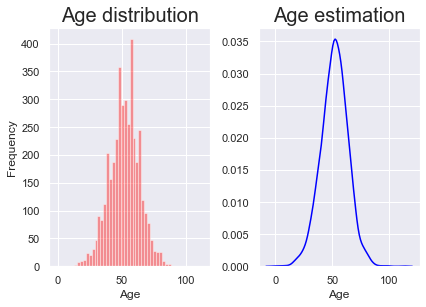

In [1375]:
fig, ax = plt.subplots(1,2)
fig.tight_layout() #nastavenie odsadenia medzi grafmi
sns.distplot(personal['age'].dropna(),bins=None, kde=False, color = "red", ax=ax[0])
ax[0].set_title('Age distribution', fontsize = 20)
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Frequency')
sns.distplot(personal['age'].dropna(),bins=None, hist=False, color = "blue", ax=ax[1])
ax[1].set_title('Age estimation', fontsize = 20)
ax[1].set_xlabel('Age')

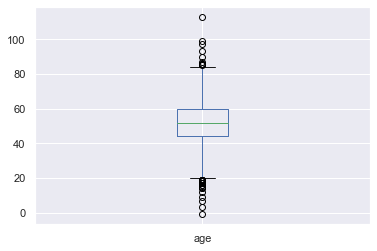

In [1376]:
# Skontrolujeme vychýlené hodnoty veku, nakoľko z grafov vyššie nemusí byť vidieť veľmi nízky alebo veľmi vysoký vek
personal.age.plot(kind='box')

Z grafu vyššie môžeme vidieť, že jeden človek má vek nižší ako 0 a jeden vyšší ako 100. Pre overenie korektnosti, si tieto dva záznamy vypíšeme:

In [1377]:
personal[(personal.age < 0) | (personal.age > 100)]

,name,address,age,sex,date_of_birth
1494,James Raspberry,"28375 Nicole Vista\r\nValerieshire, MO 11508",-1,Female,2020-01-26
3826,Clark Smith,"9472 Megan Forge\r\nNorth Selenaborough, NV 88450",113,Male,1906-07-20 00 00 00


Zobrazili sme si najkrajnejšie zaznamy, ktoré sme videli zobrazené na predchádzajúcom grafe. Vidíme, že záznam subjektu s vekom 113 má korektný dátum narodenia, čiže ho zatiaľ budeme považovať za korektný. Subjekt s vekom -1 má však nezmyselný dátum narodenia, čiže bude potrebné vyhľadať zhodujúci sa záznam v druhom datasete a zistiť, či sú aj v ňom hodnoty nezmyselné. Ak áno, záznam nám môže pokaziť náš model a radšej ho zahodíme. Stále sa však môže jednať o preklep alebo nejakú chybu v systéme.

In [1378]:
other[(other.name == 'James Raspberry')]

,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,capital-gain,...,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
2939,James Raspberry,"28375 Nicole Vista\r\nValerieshire, MO 11508",4.928024,?,Never-married,f,3.0,Unmarried,29.791218,0.0,...,Mexico,0.0,6.810201,45.0,White,?,135.164062,50.852541,0.016696,0.065705


Ostané údaje vyzerajú byť v poriadku, takže záznam nevymažeme, ale aby chybný vek neovplyvnil priemerný vek, nahradíme ho mediánom.

In [1379]:
personal.loc[1494, 'age'] = personal.age.median()
personal[(personal.index == 1494)]

,name,address,age,sex,date_of_birth
1494,James Raspberry,"28375 Nicole Vista\r\nValerieshire, MO 11508",52.0,Female,2020-01-26


In [1380]:
# výpočet priemerného veku:
personal.age.mean()

51.83040935672515

Z grafu je vidieť, že vek má normálne rozdelenie. Priemerný vek je približne 52 rokov.

### 1.3.2 sex

Counter({' Male': 2651, ' Female': 1282})


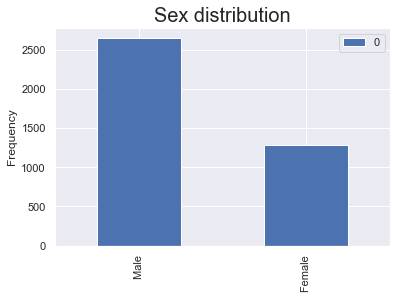

In [1381]:
#TODO: graf rozdelenia pohlavi subjekov
count = Counter(personal.sex)
df = pd.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', legend = True)
plt.title('Sex distribution', fontsize=20)
plt.ylabel('Frequency')
print(count)

In [1382]:
personal.sex.unique()

array([' Male', ' Female'], dtype=object)

In [1383]:
men_count = len(personal[(personal.sex == ' Male')])
men_count / len(personal) * 100

67.40401728960082

Môžeme vidieť, že mužov je približne 67%, čiže žien bude zvyšných 33%. <br />
V atribúte 'sex' sa nachádzajú iba hodnoty 'Male' a 'Female', čiže netreba riešiť žiadne chýbajúce alebo odlišné hodnoty. Avšak obe hodnoty majú na začiatku zbytočnú medzeru, t.j. ' Male', ' Female'. Túto medzeru by bolo vhodné odstrániť.

In [1384]:
# Odstránenie medzier spred hodnôt
personal.sex = personal.sex.str.strip()

### 1.3.3 date_of_birth

In [1385]:
personal['date_of_birth'].head(30)

0     17/06/1965         
1     1967-12-19         
2     1954-06-27         
3     1983-03-29         
4     1988-11-29         
5     1960-03-11         
6     74-08-11           
7     1957-12-17         
8     1945-05-02 00 00 00
9     1962-05-03 00:00:00
10    1962-07-30         
11    1954-10-11 00:00:00
12    1948-12-06         
13    1974-03-17         
14    73-04-28           
15    1976-04-29 00 00 00
16    1977-06-17         
17    1968-06-19         
18    1963-03-24 00 00 00
19    1962-11-18 00:00:00
20    1950-09-11         
21    1979-01-07         
22    1954/10/18         
23    1984-06-01         
24    1957-08-02         
25    1966-04-25         
26    1965-07-26         
27    1968-11-24 00 00 00
28    1971-10-15         
29    1967/01/08         
Name: date_of_birth, dtype: object

Z výpisu vyššie môžeme vidieť, že dataset obsahuje niekoľko rôznych formátov zápisu dátumov narodenia:
* DD/MM/YYYY
* YYYY-MM-DD
* YY-MM-DD
* YYYY-MM-DD hh:mm:ss
* YYYY-MM-DD hh mm ss 

Bude potrebné zvoliť jednotný formát a tiež odstrániť časové zložky.

In [1386]:
len(personal[(personal['date_of_birth'].str.contains(' '))])

498

Našli sme všetky záznamy obsahujúce časovú zložku v dátume narodenia. Ich počet je 498. Z týchto dátumov môžeme odstrániť všetky znaky za prvou medzerou (vrátane) - nakoľko môžeme vidieť, že vo formátoch sa medzera vyskytuje vždy až za dátumom narodenia.

In [1387]:
#df['DOB1'] = df['DOB'].dt.strftime('%m/%d/%Y')
#personal['date_of_birth'] = personal['date_of_birth'].dt.strftime('%d/%m/%Y')

In [1388]:
# Odstránenie časových zložiek z dátumov narodenia
personal['date_of_birth'] = personal['date_of_birth'].apply(lambda x: x.split(' ')[0])
len(personal[(personal['date_of_birth'].str.contains(' '))])

0

V ďalšej fáze projektu budeme všetky formáty dátumov konvertovať na jeden typ (DD/MM/YYYY)

### 1.3.4 class

In [1389]:
other['class'].unique()

array([ 1.,  0., nan])

In [1390]:
other[(other["class"] != 1) & (other["class"] != 0)]

,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,capital-gain,...,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
101,Jesus Barnhill,"6188 Jones Corners Suite 722\r\nMaryview, WV 66853",0.476516,Other-service,Never-married,f,-900.0,Own-child,93.174313,0.0,...,Puerto-Rico,0.0,86.353679,40.0,White,NaN,63.695312,31.297354,2.988502,15.509307
896,Rusty Thornton,"036 Johnson Wells Suite 764\r\nEast Theresaville, GA 37735",6.300527,Other-service,Married-civ-spouse,f,10.0,Husband,NaN,NaN,...,United-States,0.0,4.484114,40.0,White,NaN,156.046875,60.136935,0.320961,0.632663
991,Steven Coon,"5396 Kramer Common Apt. 129\r\nBlackburnshire, WV 26628",13.554053,Adm-clerical,Divorced,F,9.0,Unmarried,14.065352,0.0,...,United-States,0.0,1.348662,35.0,NaN,Private,112.062500,46.455077,0.293543,0.156486
1062,Larry Frazier,"3383 Elizabeth Courts\r\nNew Chaseview, SD 21291",9.218707,Exec-managerial,Married-civ-spouse,f,13.0,Husband,16.987123,NaN,...,United-States,0.0,2.142977,50.0,White,Private,114.070312,49.162864,0.244839,0.190308
1216,Thomas Taylor,"78667 Hernandez Mount\r\nClarkborough, WA 22409",-1.785377,NaN,Divorced,f,12.0,NaN,59.737720,4101.0,...,United-States,NaN,176.119565,40.0,White,Private,44.867188,45.693334,2.888739,8.810673
1680,Henry Glenn,"6345 Deborah Keys Suite 890\r\nNorth Christopher, GA 56439",NaN,Exec-managerial,NaN,f,13.0,Unmarried,16.329097,0.0,...,United-States,0.0,2.720736,50.0,White,private,NaN,NaN,NaN,NaN
1841,Freddie Mederios,"5604 Kara Plains Suite 644\r\nEast Timview, HI 79805",3.993995,Sales,Never-married,f,9.0,Own-child,42.661566,0.0,...,United-States,0.0,12.502508,40.0,White,Private,76.054688,60.412942,1.432917,0.936654
1886,Greg Spivey,"756 Ramos Canyon\r\nLake Scottview, NH 28478",4.322444,NaN,Married-civ-spouse,NaN,11.0,Husband,43.980061,0.0,...,United-States,0.0,10.596154,40.0,NaN,Private,NaN,NaN,NaN,NaN
2602,Stacy Harriott,"116 Rebecca Turnpike Apt. 663\r\nSimsland, NC 58407",10.049017,Sales,Divorced,f,9.0,NaN,16.740221,0.0,...,United-States,0.0,2.225753,NaN,White,NaN,122.546875,56.703568,0.067255,0.609780
3526,Walter Smith,"00546 Stephanie Course\r\nEast Bryanhaven, KS 26304",7.337484,Prof-specialty,NaN,f,13.0,Unmarried,21.531941,0.0,...,United-States,0.0,3.510033,40.0,White,private,106.945312,47.051220,0.153808,0.336252


V niektorych zaznamoch nemáme zapísane, či má pacient cukrovku alebo nie. Tieto záznamy sú pre naše zadanie v podstate zbytočné, pretože neobsahujú predikovanú hodnotu. Môžeme si však zatiaľ ponechať tie, ktoré majú ostatné atribúty v poriadku. Môžu nám spresniť výpočty priemeru, mediánu atď. 

Counter({0.0: 2958, 1.0: 1014})


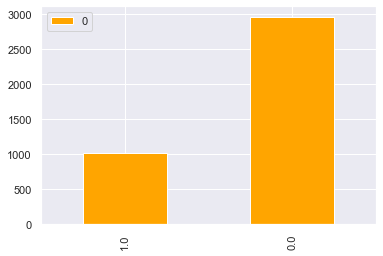

In [1391]:
df = other[(other["class"] == 1) | (other["class"] == 0)]["class"]
count = Counter(df)
df = pd.DataFrame.from_dict(count, orient='index')
ax = df.plot(kind='bar', legend = True, color = "orange")
print(count)

In [1392]:
diabetes_count = len(other[(other['class'] == 1)])
diabetes_count / len(other[pd.notnull(other['class'])]) * 100
#diabetes_count / len(other) * 100

25.528700906344408

Približne 25.53% ľudí má cukrovku. Zvyšných 74.47% cukrovku nemajú. Ľudia, ktorí nemajú zadanú hodnotu class nie sú do percentuálneho podielu započítaní.

In [1393]:
len(other[pd.isnull(other['class'])])

11

11 záznamov nemá určenú hodnotu class. Tieto záznamy pre nás v podstate strácajú význam a budú sa v dalšej fáze projektu odstraňovať.

### 1.3.5 mean_oxygen

Text(0.5, 12.5, 'mean_oxygen')

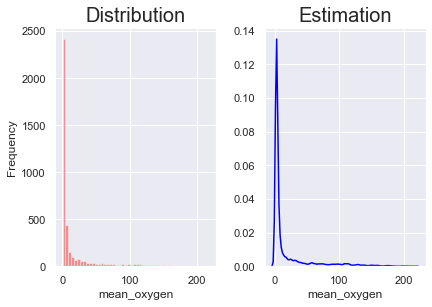

In [1394]:
fig, ax = plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other['mean_oxygen'].dropna(),bins=None, kde=False, color = "red", ax=ax[0])
ax[0].set_title('Distribution', fontsize = 20)
ax[0].set_xlabel('mean_oxygen')
ax[0].set_ylabel('Frequency')
sns.distplot(other['mean_oxygen'].dropna(),bins=None, hist=False, color = "blue", ax=ax[1])
ax[1].set_title('Estimation', fontsize = 20)
ax[1].set_xlabel('mean_oxygen')

In [1395]:
other.describe()["mean_oxygen"]

count    3972.000000
mean     18.504313  
std      34.837091  
min      0.213211   
25%      2.069189   
50%      3.234532   
75%      12.619983  
max      217.371238 
Name: mean_oxygen, dtype: float64

V deskriptívnej štatistike vidíme, že minimálna a maximálna hodnota tohoto atribútu sa drasticky líšia. Pravdepodobne to znamená, že hodnota je zaznamenaná vo viacerých mierkach. Bude preto potrebné ju konvertovať na jednotnú mierku.

### 1.3.6 std_oxygen

Text(0.5, 12.5, 'std_oxygen')

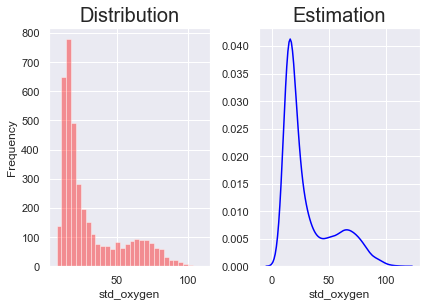

In [1396]:
fig, ax = plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other['std_oxygen'].dropna(),bins=None, kde=False, color = "red", ax=ax[0])
ax[0].set_title('Distribution', fontsize = 20)
ax[0].set_xlabel('std_oxygen')
ax[0].set_ylabel('Frequency')
sns.distplot(other['std_oxygen'].dropna(),bins=None, hist=False, color = "blue", ax=ax[1])
ax[1].set_title('Estimation', fontsize = 20)
ax[1].set_xlabel('std_oxygen')

In [1397]:
other.describe()["std_oxygen"]

count    3968.000000
mean     31.158976  
std      22.265708  
min      7.370432   
25%      15.064858  
50%      20.579902  
75%      43.229414  
max      110.642211 
Name: std_oxygen, dtype: float64

### 1.3.7 kurtosis_oxygen

Text(0.5, 12.5, 'kurtosis_oxygen')

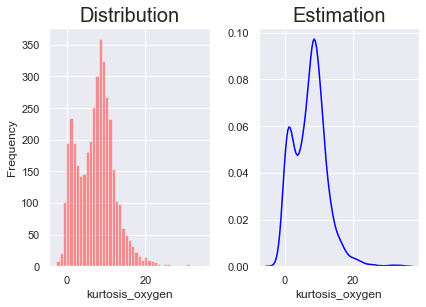

In [1398]:
fig, ax = plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other['kurtosis_oxygen'].dropna(),bins=None, kde=False, color = "red", ax=ax[0])
ax[0].set_title('Distribution', fontsize = 20)
ax[0].set_xlabel('kurtosis_oxygen')
ax[0].set_ylabel('Frequency')
sns.distplot(other['kurtosis_oxygen'].dropna(),bins=None, hist=False, color = "blue", ax=ax[1])
ax[1].set_title('Estimation', fontsize = 20)
ax[1].set_xlabel('kurtosis_oxygen')

In [1399]:
other.describe()["kurtosis_oxygen"]

count    3969.000000
mean     7.423042   
std      4.846216   
min     -2.597872   
25%      3.637833   
50%      7.781618   
75%      10.259075  
max      34.539844  
Name: kurtosis_oxygen, dtype: float64

### 1.3.8 skewness_oxygen

Text(0.5, 12.5, 'skewness_oxygen')

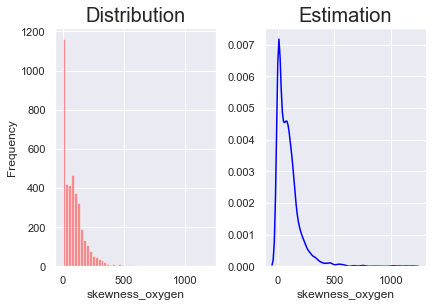

In [1400]:
fig, ax = plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other['skewness_oxygen'].dropna(),bins=None, kde=False, color = "red", ax=ax[0])
ax[0].set_title('Distribution', fontsize = 20)
ax[0].set_xlabel('skewness_oxygen')
ax[0].set_ylabel('Frequency')
sns.distplot(other['skewness_oxygen'].dropna(),bins=None, hist=False, color = "blue", ax=ax[1])
ax[1].set_title('Estimation', fontsize = 20)
ax[1].set_xlabel('skewness_oxygen')

In [1401]:
other.describe()["skewness_oxygen"]

count    3964.000000
mean     91.795908  
std      110.770563 
min     -1.976976   
25%      12.966818  
50%      68.623477  
75%      126.894595 
max      1191.000837
Name: skewness_oxygen, dtype: float64

### 1.3.9 mean_glucose

Text(0.5, 12.5, 'mean_glucose')

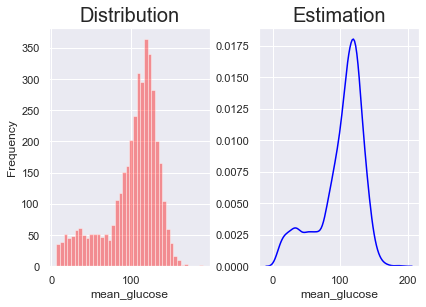

In [1402]:
fig, ax = plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other['mean_glucose'].dropna(),bins=None, kde=False, color = "red", ax=ax[0])
ax[0].set_title('Distribution', fontsize = 20)
ax[0].set_xlabel('mean_glucose')
ax[0].set_ylabel('Frequency')
sns.distplot(other['mean_glucose'].dropna(),bins=None, hist=False, color = "blue", ax=ax[1])
ax[1].set_title('Estimation', fontsize = 20)
ax[1].set_xlabel('mean_glucose')

In [1403]:
other.describe()["mean_glucose"]

count    3966.000000
mean     101.214367 
std      33.597457  
min      6.187500   
25%      87.736328  
50%      110.613281 
75%      124.115234 
max      189.734375 
Name: mean_glucose, dtype: float64

Hodnota glukózy v krvi zvykne normálne byť zadaná v desiatkach, nie v stovkách ako je to v našom datasete. Bude preto potrebné konvertovať tieto dáta na jednotnú mierku. 

### 1.3.10 std_glucose

Text(0.5, 12.5, 'std_glucose')

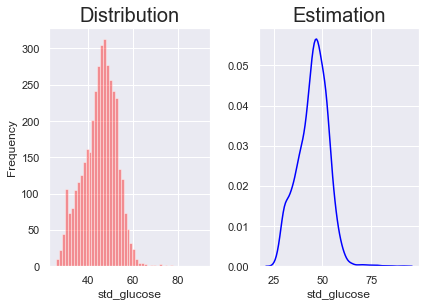

In [1404]:
fig, ax = plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other['std_glucose'].dropna(),bins=None, kde=False, color = "red", ax=ax[0])
ax[0].set_title('Distribution', fontsize = 20)
ax[0].set_xlabel('std_glucose')
ax[0].set_ylabel('Frequency')
sns.distplot(other['std_glucose'].dropna(),bins=None, hist=False, color = "blue", ax=ax[1])
ax[1].set_title('Estimation', fontsize = 20)
ax[1].set_xlabel('std_glucose')

In [1405]:
other.describe()["std_glucose"]

count    3966.000000
mean     45.169444  
std      7.629204   
min      25.695250  
25%      40.128532  
50%      45.878359  
75%      50.369118  
max      91.206475  
Name: std_glucose, dtype: float64

### 1.3.11 kurtosis_glucose

Text(0.5, 12.5, 'kurtosis_glucose')

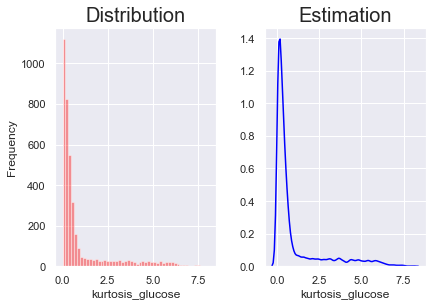

In [1406]:
fig, ax = plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other['kurtosis_glucose'].dropna(),bins=None, kde=False, color = "red", ax=ax[0])
ax[0].set_title('Distribution', fontsize = 20)
ax[0].set_xlabel('kurtosis_glucose')
ax[0].set_ylabel('Frequency')
sns.distplot(other['kurtosis_glucose'].dropna(),bins=None, hist=False, color = "blue", ax=ax[1])
ax[1].set_title('Estimation', fontsize = 20)
ax[1].set_xlabel('kurtosis_glucose')

In [1407]:
other.describe()["kurtosis_glucose"]

count    3966.000000
mean     1.012966   
std      1.580512   
min      0.000154   
25%      0.141444   
50%      0.331311   
75%      0.811816   
max      8.069522   
Name: kurtosis_glucose, dtype: float64

### 1.3.12 skewness_glucose

Text(0.5, 12.5, 'skewness_glucose')

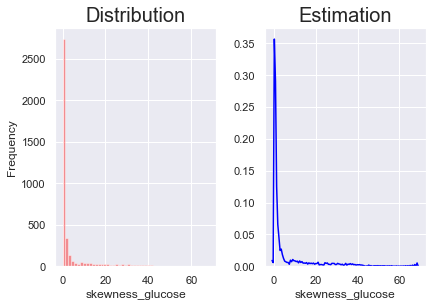

In [1408]:
fig, ax = plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other['skewness_glucose'].dropna(),bins=None, kde=False, color = "red", ax=ax[0])
ax[0].set_title('Distribution', fontsize = 20)
ax[0].set_xlabel('skewness_glucose')
ax[0].set_ylabel('Frequency')
sns.distplot(other['skewness_glucose'].dropna(),bins=None, hist=False, color = "blue", ax=ax[1])
ax[1].set_title('Estimation', fontsize = 20)
ax[1].set_xlabel('skewness_glucose')

In [1409]:
other.describe()["skewness_glucose"]

count    3966.000000
mean     4.440400   
std      9.647700   
min      0.000108   
25%      0.229751   
50%      0.526528   
75%      2.088449   
max      68.101622  
Name: skewness_glucose, dtype: float64

# 2. Párová analýza

## 2.1 Porovnanie distribúcií atribútov pri ľudoch s a bez ochorenia
Teraz by sme potrebovali zistiť, ako vyzerajú hodnoty týchto atribútov pri ľudoch s cukrovkou a ľudoch bez tohoto ochorenia. Červeným sú označení ľudia, ktorým bola diagnostikovaná cukrovka, zeleným sú ľudia ktorí toto ochorenie nemajú.

### 2.1.1 mean_glucose

Text(0.5, 1, 'class = 0')

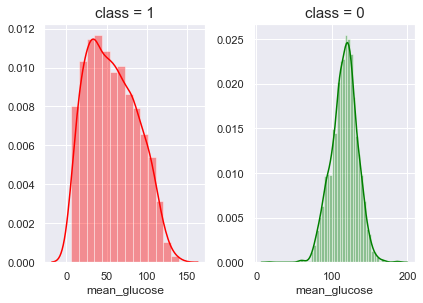

In [1410]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other[other["class"]== 1]['mean_glucose'].dropna(),bins=None, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['mean_glucose'].dropna(),bins=None, color = "green", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

### 2.1.2 std_glucose

Text(0.5, 1, 'class = 0')

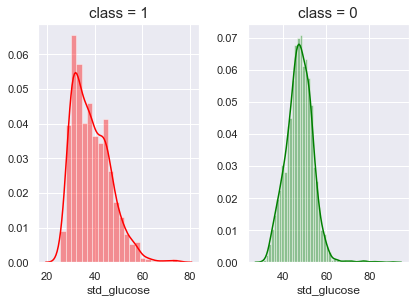

In [1411]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other[other["class"]== 1]['std_glucose'].dropna(),bins=None, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['std_glucose'].dropna(),bins=None, color = "green", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

### 2.1.3 mean_oxygen

Text(0.5, 1, 'class = 0')

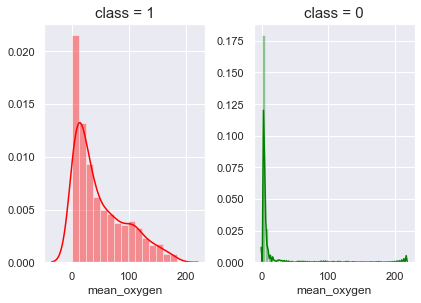

In [1412]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other[other["class"]== 1]['mean_oxygen'].dropna(),bins=None, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['mean_oxygen'].dropna(),bins=None, color = "green", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

### 2.1.4 std_oxygen

Text(0.5, 1, 'class = 0')

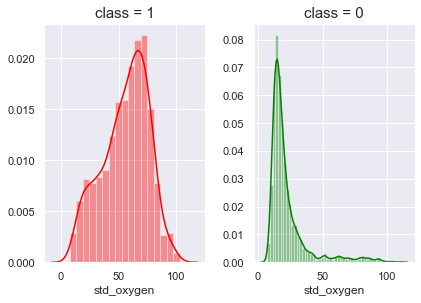

In [1413]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other[other["class"]== 1]['std_oxygen'].dropna(),bins=None, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['std_oxygen'].dropna(),bins=None, color = "green", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

## 2.2 Korelácie

O koreláciách dvoch premenných vieme povedať, že ak hodnota korelácie sa blíži k 1, hodnoty sú priamo závislé. Naopak, ak sa hodnota korelácie blíži k -1, hodnoty sú závislé nepriamo. Hodnoty korelácie okolo 0 znamenajú, že hodnoty nie sú závislé a hodnoty medzi 0.5 a -0.5 môžu znamenať náhodné závislosti.

Korelácie budeme vykreslovať pomocou scatterplotu, na základe ktorého môžeme vizualizovať závislosti medzi zvolenými atribútmi - atribúty, ktoré silno korelujú sa budú prirodzene zhlukovať.

### 2.2.1 korelačná matica

In [1414]:
corr = other.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,kurtosis_oxygen,education-num,std_oxygen,capital-gain,skewness_oxygen,fnlwgt,class,capital-loss,mean_oxygen,hours-per-week,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
kurtosis_oxygen,1,-0.0106,-0.843,-0.00861,0.915,-0.0123,-0.556,0.00166,-0.66,-0.0189,0.473,0.248,-0.538,-0.478
education-num,-0.0106,1,0.00271,-0.0237,-0.0127,-0.0185,-0.00458,0.014,-0.000724,-0.0362,-0.011,-0.00491,0.00871,0.0138
std_oxygen,-0.843,0.00271,1,0.0102,-0.605,0.00217,0.65,-0.00879,0.802,0.0248,-0.561,-0.275,0.635,0.559
capital-gain,-0.00861,-0.0237,0.0102,1,-0.00631,-0.0188,-0.00844,-0.0325,0.00433,0.0892,0.0165,-0.00157,-0.00871,-0.00367
skewness_oxygen,0.915,-0.0127,-0.605,-0.00631,1,-0.0147,-0.385,-0.00743,-0.394,-0.00605,0.304,0.191,-0.347,-0.308
fnlwgt,-0.0123,-0.0185,0.00217,-0.0188,-0.0147,1,-0.0172,0.00548,0.0106,-0.0353,0.0243,0.0153,-0.0148,-0.0123
class,-0.556,-0.00458,0.65,-0.00844,-0.385,-0.0172,1,-0.00609,0.518,0.0151,-0.775,-0.5,0.785,0.676
capital-loss,0.00166,0.014,-0.00879,-0.0325,-0.00743,0.00548,-0.00609,1,-0.02,0.0582,0.00187,-0.0155,-0.00369,-0.0044
mean_oxygen,-0.66,-0.000724,0.802,0.00433,-0.394,0.0106,0.518,-0.02,1,0.0234,-0.544,-0.203,0.614,0.554
hours-per-week,-0.0189,-0.0362,0.0248,0.0892,-0.00605,-0.0353,0.0151,0.0582,0.0234,1,-0.00884,-0.00513,0.00893,0.00687


### 2.2.2 mean_glucose a std_glucose

In [1415]:
other['mean_glucose'].corr(other['std_glucose'])

0.6454646090376697

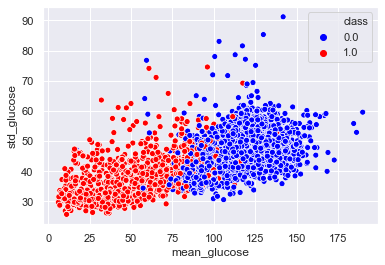

In [1416]:
sns.scatterplot(x='mean_glucose', y='std_glucose', hue='class', data=other, palette = ['blue', 'red'])

### 2.2.3 skewness_oxygen a kurtosis_oxygen

In [1417]:
other['skewness_oxygen'].corr(other['kurtosis_oxygen'])

0.9152409702436162

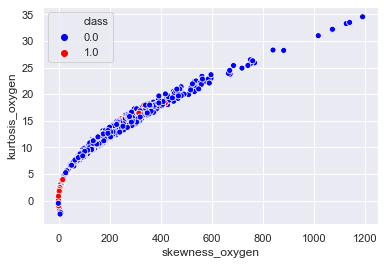

In [1418]:
sns.scatterplot(x='skewness_oxygen', y='kurtosis_oxygen', hue='class', data=other, palette = ['blue', 'red'])

### 2.2.4 std_oxygen a kurtosis_oxygen

In [1419]:
other['std_oxygen'].corr(other['kurtosis_oxygen'])

-0.8434688216526309

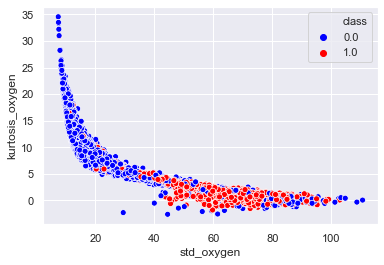

In [1420]:
sns.scatterplot(x='std_oxygen', y='kurtosis_oxygen', hue='class', data=other, palette = ['blue', 'red'])

### 2.2.5 kurtosis_glucose a skewness_glucose

In [1421]:
other['kurtosis_glucose'].corr(other['skewness_glucose'])

0.96595719995955

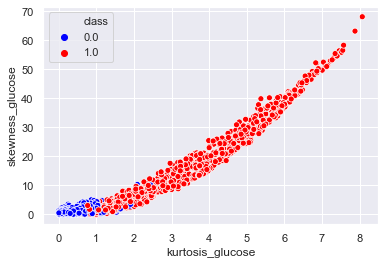

In [1422]:
sns.scatterplot(x='kurtosis_glucose', y='skewness_glucose', hue='class', data=other, palette = ['blue', 'red'])

### 2.2.6 kurtosis_glucose a mean_glucose

In [1423]:
other['kurtosis_glucose'].corr(other['mean_glucose'])

-0.9009069142625682

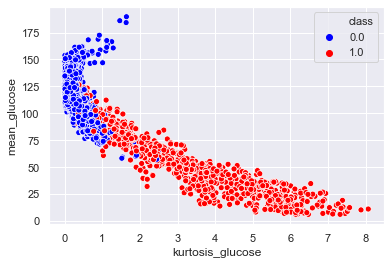

In [1424]:
sns.scatterplot(x='kurtosis_glucose', y='mean_glucose', hue='class', data=other, palette = ['blue', 'red'])

## 2.3 Korelácie s predikovanou premennou

In [1425]:
other.corr()['class']

kurtosis_oxygen    -0.555643
education-num      -0.004584
std_oxygen          0.650266
capital-gain       -0.008443
skewness_oxygen    -0.385221
fnlwgt             -0.017244
class               1.000000
capital-loss       -0.006092
mean_oxygen         0.518284
hours-per-week      0.015091
mean_glucose       -0.775109
std_glucose        -0.500295
kurtosis_glucose    0.784912
skewness_glucose    0.675967
Name: class, dtype: float64

Z výpisu vyššie môžeme vidieť, že s predikovanou premennou najviac koreluje atribút kurtosis_glucose. Ďalej tiež korelujú atribúty mean_glucose (nepriamo), skewness_glucose, std_oxygen a kurtosis_oxygen (nepriamo). Tieto atribúty by teda mohli potencíalne byť dobrými prediktoromi cukrovky v našom datasete.

# 3. Hypotézy 

* Ľudia s cukrovkou majú menšiu priemernú hladinu glukózy v krvi ako ľudia bez tohoto ochorenia 
* Ľudia s cukrovkou majú väčšiu priemernú hladinu kyslíku v krvi ako ľudia bez cukrovky

## 3.1 Overenie prvej hypotézy

### Shapiro-Wilkov test normálnosti:

Nulová hypotéza: dáta pochádzajú z normálneho rozdelenia

In [1426]:
diabetics = other[(other['class'] == 1) & (other['mean_glucose'].notnull())]['mean_glucose']
st.shapiro(pd.Series(diabetics).values)

(0.9693278074264526, 9.085328924731892e-14)

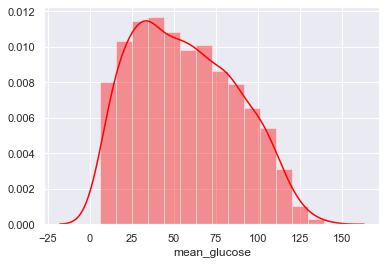

In [1427]:
sns.distplot(diabetics.dropna(),bins=None,color = "red")

In [1428]:
nondiabetics = other[(other['class'] == 0) & (other['mean_glucose'].notnull())]['mean_glucose']
st.shapiro(pd.Series(nondiabetics).values)

(0.9949914216995239, 1.8804081847179077e-08)

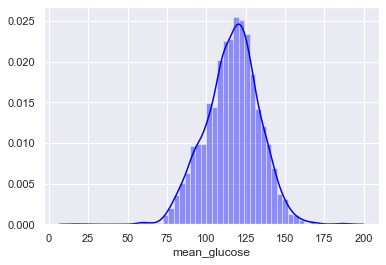

In [1429]:
sns.distplot(nondiabetics.dropna(),bins=None,color = "blue")

V oboch prípadoch je p < 0.05, takže nulovú hypotézu zamietame, nakoľko dáta sú pravdepodobne z iného ako normálneho rozdelenia.

### Levenov test:

Nulová hypotéza: všetky vstupné vzorky pochádzajú z rozdelení s rovnakými varianciami.

In [1430]:
st.levene(diabetics, nondiabetics)

LeveneResult(statistic=724.8892563569756, pvalue=9.420031929389886e-147)

Nakoľko p < 0.05, nulovú hypotézu zamietame.

Keďže oba testy zlyhali, nesplnili sa predpoklady pre t-test a musíme použiť **Mann-Whitneyho U test**

### Mann-Whitneyho U test:

Nulová hypotéza: ľudia s cukrovkou majú rovnakú priemernú hladinu glukózy v krvi ako ľudia bez tohoto ochorenia.

In [1431]:
st.mannwhitneyu(diabetics, nondiabetics)

MannwhitneyuResult(statistic=144311.5, pvalue=0.0)

Keďže p < 0.05, vieme povedať, že náhodne vybraná hodnota hladiny cukru v krvi človeka s cukrovkou je buď väčšia alebo menšia ako náhodne vybraná hodnota hladiny cukru v krvi človeka bez tohoto ochorenia. Nulovú hypotézu teda zamietame, čím potvrdzujeme našu hypotézu.

## 3.2 Overenie druhej hypotézy

### Shapiro-Wilkov test normálnosti:

In [1432]:
diabetics = other[(other['class'] == 1) & (other['mean_oxygen'].notnull())]['mean_oxygen']
st.shapiro(pd.Series(diabetics).values)

(0.8756073713302612, 1.202241160333327e-27)

In [1433]:
nondiabetics = other[(other['class'] == 0) & (other['mean_oxygen'].notnull())]['mean_oxygen']
st.shapiro(pd.Series(nondiabetics).values)

(0.3006325960159302, 0.0)

p < 0.05 v oboch prípadoch, takže nulovú hypotézu zamietame.

### Levenov test:

In [1434]:
st.levene(diabetics, nondiabetics)

LeveneResult(statistic=1055.732021554439, pvalue=1.6640861541989152e-205)

Nakoľko nie sú splnené podmienky pre t-test, pretože p < 0.05, nulovú hypotézu zamietame a dáta otestujeme pomocou **Mann-Whitneyho U testu**

### Mann-Whitneyho U test:

Nulová hypotéza: ľudia s cukrovkou majú rovnakú priemernú hladinu kyslíku v krvi ako ľudia bez cukrovky

In [1435]:
st.mannwhitneyu(diabetics, nondiabetics)

MannwhitneyuResult(statistic=310650.5, pvalue=4.7242842290638e-310)

Keďže p < 0.05, nulovú hypotézu zamietame, čím potvrdzujeme našu hypotézu.

# 4. Identifikácia problémov a návrh ich riešenia

## 4.1 Chýbajúce hodnoty

In [1436]:
other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 25 columns):
name                3983 non-null object
address             3983 non-null object
kurtosis_oxygen     3969 non-null float64
occupation          3970 non-null object
marital-status      3967 non-null object
pregnant            3968 non-null object
education-num       3572 non-null float64
relationship        3969 non-null object
std_oxygen          3968 non-null float64
capital-gain        3969 non-null float64
skewness_oxygen     3964 non-null float64
education           3971 non-null object
fnlwgt              3974 non-null float64
class               3972 non-null float64
income              3971 non-null object
native-country      3966 non-null object
capital-loss        3966 non-null float64
mean_oxygen         3972 non-null float64
hours-per-week      3967 non-null float64
race                3970 non-null object
workclass           3739 non-null object
mean_glucose        39

Môžeme vidieť, že celkový počet záznamov je 3983. Z toho vyplýva, že všetky atribúty, ktoré majú menej záznamov, obsahujú aspoň jednu null hodnotu. V takomto prípade je potrebné hodnoty doplniť. Hodnoty však treba doplniť tak, aby neboli príliš vychýlené. V prípade číselných hodnôt môžeme doplniť medián, ale napríklad pri atribúte 'pregnant' treba rozlíšiť pohlavie a sa jedná o ženu, až potom sa pridelí hodnota na základe priemeru. 

Veľký problém môžu spôsobovať null hodnoty v predikovanej premennej, pretože na základe tejto hodnoty určujeme či má daný človek cukrovku alebo nie. Keďže hlavným cieľom projektu je vytvoriť model, ktorý sa naučí predikovať cukrovku na našom datasete, záznamy ktoré nemajú určenú triedu class nám nie sú k takmer žiadnemu užitku. Určite sa teda budú odstraňovať, no zatiaľ si ich môžme ponechať na presnejší výpočet mediánov alebo priemerov.

## 4.2 Nejednotné formáty dát

Ako sme už spomínali v časti 1.3.3, dátum narodenia má niekoľko formátov zápisu, ktoré bude treba upraviť na jednotný zápis. Podobne bude potrebné skontrolovať a prípadne upraviť formát zápisu adresy, nakoľko na základe adresy a mena budeme spájať dataframy.

In [1437]:
personal['date_of_birth'].head(15)

0     17/06/1965
1     1967-12-19
2     1954-06-27
3     1983-03-29
4     1988-11-29
5     1960-03-11
6     74-08-11  
7     1957-12-17
8     1945-05-02
9     1962-05-03
10    1962-07-30
11    1954-10-11
12    1948-12-06
13    1974-03-17
14    73-04-28  
Name: date_of_birth, dtype: object

In [1438]:
other["pregnant"].unique()

array(['f', 'TRUE', 'FALSE', 'F', 't', nan, 'T'], dtype=object)

Atribút pregnant nadobúda množstvo rôznych hodnôt(6 + NaN), pričom reprezentuje len 2 stavy - človek je alebo nie je tehotný. Počet nadobúdaných hodnôt bude preto potrebné redukovať.

In [1439]:
other["occupation"].unique()

array([' Other-service', ' Transport-moving', ' Prof-specialty',
       ' Craft-repair', ' Exec-managerial', ' Machine-op-inspct',
       ' Adm-clerical', ' Tech-support', ' Sales', ' Prof_specialty',
       ' Farming-fishing', ' Machine_op_inspct', ' Tech_support',
       ' Handlers-cleaners', ' ?', ' Craft_repair', ' Adm_clerical',
       ' Protective-serv', ' Exec_managerial', ' Transport_moving',
       ' Other_service', ' Farming_fishing', nan, ' Priv-house-serv',
       ' Protective_serv', ' Armed-Forces', ' Priv_house_serv',
       ' Handlers_cleaners'], dtype=object)

In [1440]:
other["occupation"].describe()

count     3970            
unique    27              
top        Exec-managerial
freq      456             
Name: occupation, dtype: object

V atribúte "occupation" sa nachádza NaN a ?. Obe hodnoty by bolo potrebné nahradiť - napríklad hodnotou Exec-managerial, keďže sa jedná o najčastejšie sa vyskytujúcu hodnotu. V podstate pri všetkých záznamoch, v ktorých sa vyskytuje NaN budeme túto chýbajúcu hodnotu nahradzovať najčastejšie sa vyskytujúcou hodnotou.

In [1441]:
other["native-country"].unique()

array([' United-States', ' Iran', ' Mexico', ' ?', ' Puerto-Rico',
       ' Canada', ' Hong', ' Japan', ' Ecuador', ' Philippines',
       ' Jamaica', ' Hungary', ' Vietnam', ' Poland', ' Nicaragua',
       ' Guatemala', ' Columbia', ' Cuba', ' India', nan, ' Germany',
       ' South', ' Haiti', ' Yugoslavia', ' Italy', ' China', ' Laos',
       ' France', ' Peru', ' El-Salvador', ' England', ' Greece',
       ' Portugal', ' Thailand', ' Trinadad&Tobago', ' Taiwan',
       ' Dominican-Republic', ' Scotland', ' Ireland', ' Honduras'],
      dtype=object)

Hodnota "?" sa môže taktiež nahradiť najčastejšie sa vyskytujúcou hodnotou v danom atribúte.

## 4.3 Vychýlené hodnoty

In [1442]:
other.describe()["mean_glucose"]

count    3966.000000
mean     101.214367 
std      33.597457  
min      6.187500   
25%      87.736328  
50%      110.613281 
75%      124.115234 
max      189.734375 
Name: mean_glucose, dtype: float64

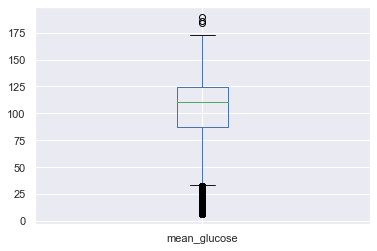

In [1443]:
other['mean_glucose'].plot(kind='box')

In [1444]:
other.describe()["mean_oxygen"]

count    3972.000000
mean     18.504313  
std      34.837091  
min      0.213211   
25%      2.069189   
50%      3.234532   
75%      12.619983  
max      217.371238 
Name: mean_oxygen, dtype: float64

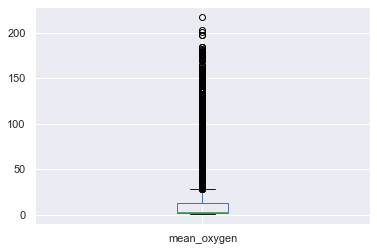

In [1445]:
other['mean_oxygen'].plot(kind='box')

In [1446]:
other.describe()['std_glucose']

count    3966.000000
mean     45.169444  
std      7.629204   
min      25.695250  
25%      40.128532  
50%      45.878359  
75%      50.369118  
max      91.206475  
Name: std_glucose, dtype: float64

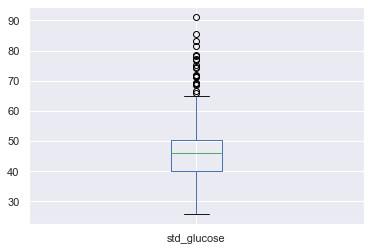

In [1447]:
other['std_glucose'].plot(kind='box')

In [1448]:
other.describe()['std_oxygen']

count    3968.000000
mean     31.158976  
std      22.265708  
min      7.370432   
25%      15.064858  
50%      20.579902  
75%      43.229414  
max      110.642211 
Name: std_oxygen, dtype: float64

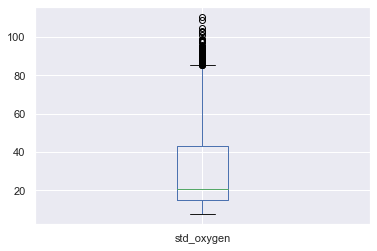

In [1449]:
other['std_oxygen'].plot(kind='box')

In [1450]:
other.describe()['kurtosis_glucose']

count    3966.000000
mean     1.012966   
std      1.580512   
min      0.000154   
25%      0.141444   
50%      0.331311   
75%      0.811816   
max      8.069522   
Name: kurtosis_glucose, dtype: float64

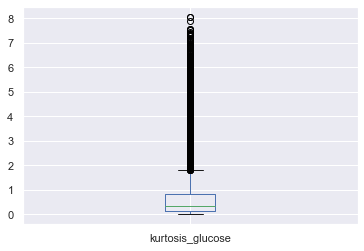

In [1451]:
other['kurtosis_glucose'].plot(kind='box')

In [1452]:
other.describe()['kurtosis_oxygen']

count    3969.000000
mean     7.423042   
std      4.846216   
min     -2.597872   
25%      3.637833   
50%      7.781618   
75%      10.259075  
max      34.539844  
Name: kurtosis_oxygen, dtype: float64

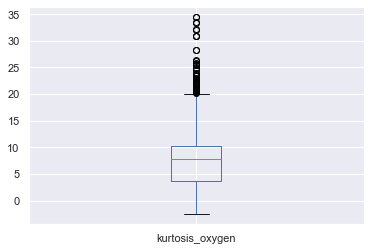

In [1453]:
other['kurtosis_oxygen'].plot(kind='box')

In [1454]:
other.describe()['skewness_glucose']

count    3966.000000
mean     4.440400   
std      9.647700   
min      0.000108   
25%      0.229751   
50%      0.526528   
75%      2.088449   
max      68.101622  
Name: skewness_glucose, dtype: float64

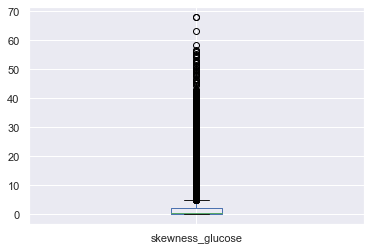

In [1455]:
other['skewness_glucose'].plot(kind='box')

In [1456]:
other.describe()['skewness_oxygen']

count    3964.000000
mean     91.795908  
std      110.770563 
min     -1.976976   
25%      12.966818  
50%      68.623477  
75%      126.894595 
max      1191.000837
Name: skewness_oxygen, dtype: float64

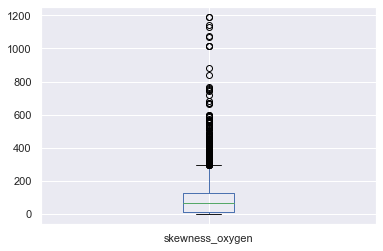

In [1457]:
other['skewness_oxygen'].plot(kind='box')

Taktiež sa nám v niekoľkých atribútoch líšia mierky, v ktorých je zapísaná daná hodnota. Napríklad v atribúte mean_glucose() sa nám nachádzajú hodnoty v rozpatí od 6 do 189. Pritom priemerná glukóza v krvi zdravého človeka máva hodnotu okolo 5. Prvá hranica je teda v rámci tejto normy, no druhá už musí byť zapísana v inom formáte a bude ju treba konvertovať. Podobná sitúacia nastáva aj v atribúte mean_oxygen (0.2 do 217).

## 4.4 Nejednoznačné mapovanie

In [1458]:
len(other)

3983

In [1459]:
len(personal)

3933

Vidíme, že sa nám nezhoduje počet záznamov medzi oboma datasetmi. Znamená to, že ich nemôžme na seba priamo namapovať pokiaľ tento problém nevyriešime. Spôsobený môže byť napríklad duplicitnými alebo úplne chýbajúcimi záznamami.

## 4.5 Nevhodná štruktúra dát
Pri prvotnom načítaní datasetu other_train.csv sme mali v jednom atribúte medical info uložené 4 numerické hodnoty - mean_glucose, std_glucose, kurtosis_glucose a skewness_glucose. Už sme ich však rozdelili na 4 nové atribúty, čiže tento problém by už mal byť vyriešený.

# 5. Predspracovanie
Druhé odovzdanie: 

## 5.1 Integrácia dát a deduplikácia záznamov
Keďže sme po porovnaní dĺžky záznamov v oboch datasetoch videli, že sa ich dĺžky odlišujú, je pravdepobodné, že v datasete other(keďže mal viac záznamov) sa budú nachádzať nejaké duplikáty. Preto si vypíšeme všetky duplikáty. Vo výpise môžeme vidieť, že máme 99 duplikátov.

In [2107]:
other[other[['name', 'address']].duplicated(keep=False)].sort_values("name")

,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,capital-gain,...,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
2056,Aaron Noman,"PSC 0351, Box 8841\r\nAPO AA 86063",7.439684,NaN,NaN,f,NaN,Husband,20.851866,0.0,...,United-States,0.0,3.191472,40.0,White,?,101.132812,37.641062,0.477774,1.535555
2230,Aaron Noman,"PSC 0351, Box 8841\r\nAPO AA 86063",NaN,?,Married-civ-spouse,f,900.0,Husband,20.851866,NaN,...,United-States,0.0,3.191472,40.0,White,?,101.132812,37.641062,0.477774,1.535555
1006,Alexander Mohammad,"PSC 9812, Box 2337\r\nAPO AA 80493",8.283575,NaN,Never-married,f,14.0,Not-in-family,22.148724,NaN,...,NaN,0.0,2.923077,NaN,White,State-gov,NaN,NaN,NaN,NaN
468,Alexander Mohammad,"PSC 9812, Box 2337\r\nAPO AA 80493",8.283575,Prof-specialty,Never-married,f,14.0,Not-in-family,22.148724,0.0,...,United-States,0.0,2.923077,40.0,White,State-gov,119.523438,56.555002,0.057768,0.736245
3102,Alfred Hall,"71320 John Forks\r\nWest Ashley, NH 21322",6.716207,Adm-clerical,Widowed,f,900.0,Unmarried,19.496749,0.0,...,NaN,0.0,3.723244,40.0,NaN,NaN,108.273438,34.664624,0.503002,2.078418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,Thomas Taylor,"78667 Hernandez Mount\r\nClarkborough, WA 22409",-1.785377,NaN,Divorced,f,12.0,NaN,59.737720,4101.0,...,United-States,NaN,176.119565,40.0,White,Private,44.867188,45.693334,2.888739,8.810673
3526,Walter Smith,"00546 Stephanie Course\r\nEast Bryanhaven, KS 26304",7.337484,Prof-specialty,NaN,f,13.0,Unmarried,21.531941,0.0,...,United-States,0.0,3.510033,40.0,White,private,106.945312,47.051220,0.153808,0.336252
3688,Walter Smith,"00546 Stephanie Course\r\nEast Bryanhaven, KS 26304",7.337484,Prof-specialty,Never-married,f,13.0,Unmarried,NaN,NaN,...,United-States,0.0,3.510033,NaN,White,private,106.945312,47.051220,0.153808,0.336252
694,Willie Newsome,"59886 Green Cape\r\nEast Patricia, AR 93136",0.993161,NaN,NaN,NaN,-900.0,Not-in-family,82.875369,0.0,...,United-States,0.0,59.987458,45.0,White,Private,108.632812,51.133537,0.743157,0.647276


In [2108]:
#groupneme si dataset other podla atributov name a adress, pricom berieme vzdy prvu nenulovu hodnotu - kedze sme z vypisu zistili,
#ze data su robene tzv. na preskacku - je potrebne duplikaty zlozit do jedneho zaznamu, na co nam staci tato funkcia
#final = other.groupby(["name", "address"]).first().reset_index()
#len(final)

def mergeDataFrames(df1, df2):
    #najprv deduplikacia oboch dataframov
    df1 = df1.groupby(["name", "address"]).first().reset_index()
    df2 = df2.groupby(["name", "address"]).first().reset_index()
    print (len(df1))
    print (len(df2))
    df = pd.DataFrame.merge(df1, df2, on=['name', 'address'], how='left')
    len(df1)
    len(df2)
    return df;

train = mergeDataFrames(personal, other);

3933
3933


Vidíme, že po odstránení duplikátov sa nám zhodujú dĺžky datasetov. Prišiel teda čas ich spojiť do jedného datasetu, ktorý nazveme train. Taktiež si môžeme všimnúť, že po odstránení duplikátov sa nám pomerne výrazne znížil počet null hodnôt v jednotlivých atribútoch datasetu. Napríklad pri hodnotách hovoriacich o hladine glukózy a kyslíka v krvi nám už chýba iba 1 hodnota - konkrétne pri atribúte skewness_glucose. Na porovnanie v datasete other (teda pôvodný dataset pred vykonaním deduplikácie) nám chýbalo cca 10-20 hodnôt pri každom z týchto atribútov.

In [2109]:
#train = pd.DataFrame.merge(personal, final, on=['name', 'address'], how='left')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 28 columns):
name                3933 non-null object
address             3933 non-null object
age                 3933 non-null float64
sex                 3933 non-null object
date_of_birth       3933 non-null object
kurtosis_oxygen     3933 non-null float64
occupation          3933 non-null object
marital-status      3933 non-null object
pregnant            3931 non-null object
education-num       3539 non-null float64
relationship        3933 non-null object
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3932 non-null float64
education           3933 non-null object
fnlwgt              3933 non-null float64
class               3933 non-null float64
income              3933 non-null object
native-country      3931 non-null object
capital-loss        3932 non-null float64
mean_oxygen         3933 non-null float64
hours-per-week      39

## 5.2 Popis krokov predspracovania
V tejto sekcií sa nachádza popis predspracovania jednotlivých atribútov v našom spojenom datasete nazvanom train. Atribúty Unnamed: 0 aj medical-info už boli vyriešené v predošlej časti, konkrétne ich riešia funkcie dropUnnamed a fixMedicalInfo.

### One-hot-encoding
Nasledujúca funkcia transformuje kategorické atribúty na spojené

In [2110]:
#funkcia sluziaca na onehotencoding
def createColumn(row, name, i):
    if(row[name] == i):
        return 1;
    else:
        return 0

    
def oneHotEncoding(df, name):
    df[name] = df[name].str.strip()
    encoded = df[name].unique()
    for i in encoded:
        df["is" + i] = df.apply(lambda row: createColumn(row, name, i), axis = 1)
    df = df.drop(columns = name, axis = 1)
    return df

### 5.2.1 name
Mená subjektov nebude potrebné už nijako spracúvať - všetky mena sú unikátne a pre náš model už nemajú prakticky žiaden význam, slúžili nám teda vlastne iba na spojenie datasetov personal a other. Môžeme ich teda z datasetu train už odstrániť.

In [2111]:
train.name.duplicated(keep = False)

0       False
1       False
2       False
3       False
4       False
        ...  
3928    False
3929    False
3930    False
3931    False
3932    False
Name: name, Length: 3933, dtype: bool

In [2112]:
def dropName(df):
    df = df.drop('name', axis = 1)
    return df;

train = dropName(train)

### 5.2.2 address
Adresu si zatiaľ ponecháme, keďže teoreticky môžeme používať krajinu, resp. kontinent ako potenciálny prediktor cukrovky.

In [2113]:
def dropAdress(df):
    df = df.drop('address', axis = 1)
    return df
train = dropAdress(train)

### 5.2.3 age a date_of_birth
Pri veku je potrebné ošetriť všetky potenciálne outliery - teda veky, ktoré dosahujú priveľké hodnoty alebo veky s hodnotou menšou ako 0. Vek budeme počítať pomocou dátumu narodenia, ktorý je teda prvotne potrebné upraviť na jednotný tvar. Dalším krokom bude vytvorenie vekových skupín, keďže náš model bude lepšie pracovať s údajmi pri väčšom počte záznamov.

Nasledovná funkcia prepíše rôzne formáty dátumov na jednotný formát (DD/MM/YYYY):

In [2114]:
def fitDate_of_birth(row):
    x = 0
    str1 = ''
    str2 = ''
    str3 = ''
    try:
        birth = pd.Timestamp(row['date_of_birth'])
        today = pd.Timestamp.now()
        year = birth.year
        if(year > today.year):
            year = year - 100
        if(birth.month < 10):
            month = '0' + str(birth.month)
        else:
            month = str(birth.month)
        if(birth.day < 10):
            day = '0' + str(birth.day)
        else:
            day = str(birth.day)
    except:
        if(len(row['date_of_birth']) > 10):
            row['date_of_birth'] = row['date_of_birth'][:10]
        for i in row['date_of_birth']:
            if(i == '/' or i == '-'):
                x = x + 1
            if(x == 0 and i != '/' and i != '-'):
                str1 = str1 + i
            if(x == 1 and i != '/' and i != '-'):
                str2 = str2 + i
            if(x == 2 and i != '/' and i != '-'):
                str3 = str3 + i    
        if(int(str1) == 0 or int(str2) == 0 or int(str3) == 0):
            year = min(int(str1), int(str2), int(str3))
        else:
            year = max(int(str1), int(str2), int(str3))
        if(year == int(str1)):
            month = min(int(str2), int(str3))
            day = max(int(str2), int(str3))
        elif(year == int(str2)):
            month = min(int(str1), int(str3))
            day = max(int(str1), int(str3))
        else:
            month = min(int(str1), int(str2))
            day = max(int(str1), int(str2))
        if(day < 10):
            day = '0' + str(day)
        if(month < 10):
            month = '0' + str(month)
        if(year < 19):
            year = str(2000 + year)
        elif(year < 100):
            year = str(1900 + year)
        else:
            year = str(year)
        
    date = str(day) + '/' + str(month) + '/' + str(year)
    return date
    
def transformDate_of_birth(df):
    df['date_of_birth'] = df.apply(lambda row: fitDate_of_birth(row), axis=1)
    return df

train = transformDate_of_birth(train)

Po úprave dátumu národenia prepočítame vek pacientov. Následne dátum narodenia z tabuľky odstránime, keďže nám už je v podstate zbytočný.

In [2115]:
def checkAge(row):
    today = pd.Timestamp.now()
    birth = pd.Timestamp(row['date_of_birth'])
    age = today.year - birth.year - ((today.month, today.day) < (birth.month, birth.day))
    return age
    
def changeAge(df):
    df['age'] = df.apply(lambda row: checkAge(row), axis=1)
    df = df.drop("date_of_birth", axis = 1)
    return df

train = changeAge(train)

In [2116]:
train.age.describe()

count    3933.000000
mean     51.930333  
std      11.799927  
min      3.000000   
25%      45.000000  
50%      52.000000  
75%      60.000000  
max      113.000000 
Name: age, dtype: float64

Keďže nám nevznikli žiadne nezvyčajné hodnoty, nie je riešiť žiadne outliery.

Teraz rozdelíme pacientov do kategórií podľa veku: <br>
0-18 child <br>
19-35 young adult <br>
36-60 adult <br>
61-80 senior <br>
81+ old <br>

In [2117]:
def fitAge(row):
    age = row['age']
    if(age <= 18):
        category = 'Child'
    elif(age > 18 and age <= 35):
        category = 'Young-adult'
    elif(age > 35 and age <= 60):
        category = 'Adult'
    elif(age > 60 and age <= 80):
        category = 'Senior'
    else:
        category = 'Old'
    return category
    
def transformAge(df):
    df['age'] = df.apply(lambda row: fitAge(row), axis=1)
    return df

train = transformAge(train)

Rozdelili sme vek do kategórií, aby s nimi mohol náš machine learning model lepšie pracovať. Zostáva nám teda použiť predom definovanú funkciu na one-hot-encoding a tento kategorický atribút transformovať na viacero spojitých atribútov.

In [2118]:
train = oneHotEncoding(train, "age")

In [2119]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 29 columns):
sex                 3933 non-null object
kurtosis_oxygen     3933 non-null float64
occupation          3933 non-null object
marital-status      3933 non-null object
pregnant            3931 non-null object
education-num       3539 non-null float64
relationship        3933 non-null object
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3932 non-null float64
education           3933 non-null object
fnlwgt              3933 non-null float64
class               3933 non-null float64
income              3933 non-null object
native-country      3931 non-null object
capital-loss        3932 non-null float64
mean_oxygen         3933 non-null float64
hours-per-week      3932 non-null float64
race                3933 non-null object
workclass           3700 non-null object
mean_glucose        3933 non-null float64
std_glucose         3

### 5.2.4 sex
Pohlavie konvertujeme na numerickú hodnotu, keďže môže hrať rolu pri diagnostikovaní cukrovky. Môžeme ho teda konvertovať na stĺpec s názvom isMale. V ňom bude hodnota 0 zodpovedať ženám, 1 zas mužom. Keďže vidíme, že tento atribút nenadobúda žiadne nezmyselné hodnoty a taktiež nikdy nie je nulový, nič iné ošetrovať potrebné nebude.

In [2120]:
train.sex.unique()

array(['Female', 'Male'], dtype=object)

Funkcia najskôr premenuje stĺpec 'sex' na 'isMale'. Následne odstráni prebytočné medzery z hodnôt uložených v stĺpci a nakoniec zmení hodnoty 'Male' a 'Female' na numerické hodnoty 1 a 0. Pozeráme sa aj na hodnotu atribútu relationship - ak je subjekt "Wife", jeho pohlavie bude ženské, čiže hodnota 0. Ak je subjekt "Husband", pohlavie bude 1, čiže mužské.

In [2121]:
def fitSex(row):
    if str(row['relationship'] ) == 'Wife':
        return 0;
    elif str(row['relationship']) == 'Husband':
        return 1;
    elif str(row['isMale']) == 'Male':
        return 1
    else:
        return 0

def transformSex(df):
    df = df.rename(columns={'sex' : 'isMale'})
    df.isMale = df.isMale.str.strip()
    df.relationship = df.relationship.str.strip()
    df['isMale'] = df.apply(lambda row: fitSex(row), axis=1)
    return df

train = transformSex(train)

In [2122]:
train.info()
train.isMale.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 29 columns):
isMale              3933 non-null int64
kurtosis_oxygen     3933 non-null float64
occupation          3933 non-null object
marital-status      3933 non-null object
pregnant            3931 non-null object
education-num       3539 non-null float64
relationship        3933 non-null object
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3932 non-null float64
education           3933 non-null object
fnlwgt              3933 non-null float64
class               3933 non-null float64
income              3933 non-null object
native-country      3931 non-null object
capital-loss        3932 non-null float64
mean_oxygen         3933 non-null float64
hours-per-week      3932 non-null float64
race                3933 non-null object
workclass           3700 non-null object
mean_glucose        3933 non-null float64
std_glucose         39

array([0, 1], dtype=int64)

### 5.2.5 date_of_birth
Dátum narodenia sme už z tabuľky odstránili, keďže nám slúžil len na overenie veku a pre náš model nemá v podstate žiaden iný význam.

### 5.2.6  kurtosis_oxygen

In [2123]:
train.kurtosis_oxygen.describe()

count    3933.000000
mean     7.413506   
std      4.812170   
min     -2.597872   
25%      3.637833   
50%      7.782188   
75%      10.261581  
max      34.539844  
Name: kurtosis_oxygen, dtype: float64

### 5.2.7 occupation
Atribút reprezentujúci povolanie subjektu nikdy nenadobudne nulovú hodnotu. Nadobúda však hodnotu "?", ktorá ma pre nás rovnakú výpovednú hodnotu. Túto hodnotu nadobúda 233 záznamov - nahradíme ich hodnotou NaN, ktoré budeme neskôr nahradzovať vybranou hodnotou. Taktiež sú vždy na začiatku stringov medzery - odstránime ich. Všetky tieto úpravy smerujú k vytvoreniu N nových stĺpcov.

In [2124]:
train.occupation.isnull().unique()

array([False])

In [2125]:
len(train[train["occupation"] == " ?"])

233

In [2126]:
train.occupation.unique()

array([' Exec-managerial', ' Craft-repair', ' Protective_serv', ' Sales',
       ' ?', ' Prof-specialty', ' Exec_managerial', ' Handlers-cleaners',
       ' Craft_repair', ' Machine-op-inspct', ' Other-service',
       ' Protective-serv', ' Adm-clerical', ' Tech-support',
       ' Transport_moving', ' Transport-moving', ' Adm_clerical',
       ' Prof_specialty', ' Farming-fishing', ' Other_service',
       ' Farming_fishing', ' Tech_support', ' Machine_op_inspct',
       ' Priv-house-serv', ' Handlers_cleaners', ' Armed-Forces',
       ' Priv_house_serv'], dtype=object)

In [2127]:
def fitOccupation(row):    
    
    if str(row['occupation']) in ("Exec_managerial", "Exec-managerial"):
        return "Exec";
    elif str(row['occupation']) in ("Adm-clerical", "Adm_clerical"):
        return "Adm";
    elif str(row['occupation']) in ("Priv-house-serv", "Priv_house_serv"):
        return "Serv";
    elif str(row['occupation']) in ("Prof-specialty", "Prof_specialty"):
        return "Prof"
    elif str(row['occupation']) in ("Farming-fishing", "Farming_fishing"):
        return "Farm"
    elif str(row['occupation']) in ("Other-service", "Other_service"):
        return "Other"
    elif str(row['occupation']) in ("Craft-repair", "Craft_repair"):
        return "Craft"
    elif str(row['occupation']) in ("Tech-support", "Tech_support"):
        return "TechSupp"
    elif str(row['occupation']) in ("?"):
        return np.NaN
    elif str(row['occupation']) in ("Machine-op-inspct", "Machine_op_inspct"):
        return "MachineInspct"
    elif str(row['occupation']) in ("Transport-moving", "Transport_moving"):
        return "TranspMov"
    elif str(row['occupation']) in ("Handlers-cleaners", "Handlers_cleaners"):
        return "HandlClean"
    elif str(row['occupation']) in ("Protective-serv", "Protective_serv"):
        return "Prot"
    elif str(row['occupation']) in ("Armed-Forces", "Armed_Forces"):
        return "Army"
    else:
        return row['occupation'];
    
    
def transformOccupation(df):
    df['occupation'] = df.occupation.str.strip()
    df['occupation'] = df.apply(lambda row: fitOccupation(row), axis=1)
    #df = df.rename(columns={'pregnant':'isPregnant'})
    return df;


train = transformOccupation(train)

In [2128]:
train.occupation.unique()

array(['Exec', 'Craft', 'Prot', 'Sales', nan, 'Prof', 'HandlClean',
       'MachineInspct', 'Other', 'Adm', 'TechSupp', 'TranspMov', 'Farm',
       'Serv', 'Army'], dtype=object)

Teraz je potrebné vyriešiť NaN hodnoty - budeme ich riešiť nahrádzaním za medián. Následne aplikujeme funkciu na one hot encoding, ktorá nam vytvorí nové stĺpce s binárnymi hodnotami - 0 a 1.

In [2129]:
#mozme pouzit potencialne k-nearest-neighbor
def occupationMedian(df, row):    
    if str(row['occupation']) == "nan":
        return df['occupation'].value_counts().idxmax()
    else:
        return row['occupation']

def occupationFixNaN(df):
    df['occupation'] = df.apply(lambda row: occupationMedian(df, row), axis=1)
    return df;

train = occupationFixNaN(train)
train = oneHotEncoding(train, "occupation")

In [2130]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 42 columns):
isMale              3933 non-null int64
kurtosis_oxygen     3933 non-null float64
marital-status      3933 non-null object
pregnant            3931 non-null object
education-num       3539 non-null float64
relationship        3933 non-null object
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3932 non-null float64
education           3933 non-null object
fnlwgt              3933 non-null float64
class               3933 non-null float64
income              3933 non-null object
native-country      3931 non-null object
capital-loss        3932 non-null float64
mean_oxygen         3933 non-null float64
hours-per-week      3932 non-null float64
race                3933 non-null object
workclass           3700 non-null object
mean_glucose        3933 non-null float64
std_glucose         3933 non-null float64
kurtosis_glucose    3

Atribút occupation sme rozdelili na 14 binárnych atribútov, ktoré hovoria o povolaní subjektu (každý záznam má teda vždy iba jeden výskyt čísla 1 v týchto 14 atribútoch).

### 5.2.8 marital-status
Najskôr skontrolujeme, aké hodnoty sa nachádzajú v stĺpcoch 'marital-status' a 'relationship'. Ak obsahujú zbytočné medzery, odstránime ich. Následne premenujeme 'marital-status' na 'isMarried', ktorý bude obsahovať hodnoty 0 a 1, čím rozdelíme pacientov na dve skupiny.

In [2131]:
train['marital-status'].unique()

array([' Divorced', ' Married-civ-spouse', ' Widowed', ' Never-married',
       ' Separated', ' Married-spouse-absent', ' Married-AF-spouse'],
      dtype=object)

In [2132]:
def changeMarStat(df):
    df['marital-status'] = df['marital-status'].str.strip()
    df = df.rename(columns={'marital-status' : 'isMarried'})
    marriedrows = df.index[((df['isMarried'] == 'Married-civ-spouse') | (df['isMarried'] == 'Married-AF-spouse')) & (df['relationship'] != 'Unmarried')].tolist()
    notmarrrows = df.index[(df['isMarried'] != 'Married-civ-spouse') & (df['isMarried'] != 'Married-AF-spouse')].tolist()
    df.loc[marriedrows, 'isMarried'] = 1
    df.loc[notmarrrows, 'isMarried'] = 0
    return df

train = changeMarStat(train)
train['isMarried'].unique()

array([0, 1], dtype=int64)

In [2133]:
train["isMarried"].unique()

array([0, 1], dtype=int64)

Zmenili sme atribút marital-status na boolean atribút isMarried. Ak bol vzťah subjektu Unmarried, automaticky sme zapisovali do atribútu isMarried hodnotu 0.

### 5.2.9 pregnant
Vo výpise nižšie môžeme vidieť, že atribút pregnant nadobúda v našom datasete až 6 hodnôt (7 ak rátame NaN). Keďže tento atribút hovorí o tom, či je sledovaný človek tehotný alebo nie, vieme povedať, že sa jedná o boolean hodnotu - mal by teda nadobúdať len 2 hodnoty. Bude teda potrebné konvertovať 6 hodnôt na 2 - môžeme to rovno konvertovať na hodnoty numerické, aby ich mohol používať náš model. Taktiež musíme ošetriť všetky situácie, v ktorých sú muži tehotný, čo budeme považovať za nezmysel a hodnotu nastavíme na false. Všetky NaN hodnoty budeme nastavovať na false. Nakoniec konvertujeme tieto hodnoty na numerické, pričom vytvoríme nový stĺpec s názvom isPregnant - 0 znamená, že subjekt nie je tehotný, 1 že tehotný je.

In [2134]:
train.pregnant.unique()

array(['f', 'FALSE', 'F', 't', 'T', 'TRUE', nan], dtype=object)

In [2135]:
train[(train["isMale"] == 0)].pregnant.describe()

count     1281
unique    6   
top       f   
freq      1123
Name: pregnant, dtype: object

In [2136]:
def getPregnant(row):
    
    if str(row['isMale']) == 1:
        return 0
    if str(row['pregnant']) in 'nan':
        return 0
    else:
        return row['pregnant']
    

def fillPregnant(df):
    
    df['pregnant'] = df.apply(lambda row: getPregnant(row), axis=1)
    return df


train = fillPregnant(train)

In [2137]:
train.pregnant.unique()

array(['f', 'FALSE', 'F', 't', 'T', 'TRUE', 0], dtype=object)

Predošlá funkcia nastaví všetkým záznamom, v ktorých je nastavené mužské pohlavie hodnotu pregnant na 0 - false. Taktiež nastaví všetkým záznamom, kde je NaN hodnotu pregnant 0. Teraz je potrebné zmeniť všetky možné tvary tohoto atribútu zmeniť na jednotný tvar - teda na 0 ako false a 1 ako true.

In [2138]:
def changePregnant(row):    
    
    if str(row['pregnant']) in ("f", "FALSE", "F"):
        return 0;
    if str(row['pregnant']) in ("t", "TRUE", "T"):
        return 1;
    else:
        return row['pregnant'];
    
    
def fixPregnant(df):
    
    df['pregnant'] = df.apply(lambda row: changePregnant(row), axis=1)
    df = df.rename(columns={'pregnant':'isPregnant'})
    return df;


train = fixPregnant(train)

In [2139]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 42 columns):
isMale              3933 non-null int64
kurtosis_oxygen     3933 non-null float64
isMarried           3933 non-null int64
isPregnant          3933 non-null int64
education-num       3539 non-null float64
relationship        3933 non-null object
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3932 non-null float64
education           3933 non-null object
fnlwgt              3933 non-null float64
class               3933 non-null float64
income              3933 non-null object
native-country      3931 non-null object
capital-loss        3932 non-null float64
mean_oxygen         3933 non-null float64
hours-per-week      3932 non-null float64
race                3933 non-null object
workclass           3700 non-null object
mean_glucose        3933 non-null float64
std_glucose         3933 non-null float64
kurtosis_glucose    393

V stĺpci pregnant máme teraz už iba hodnoty 0 a 1. Taktiež sme ho premenovali na isPregnant, aby lepšie reprezentoval hodnoty, ktoré sa v ňom nachádzajú. Už sa jedná o atribút spojitý, nie kategorický (keďže obsahuje integery) - automaticky sa konvertoval na numerickú hodnotu. 

### 5.2.10 education-num a education
Atribúty education-num a education spolu súvisia. Education-num je numerickou formou atribútu education. Bude však potrebné riešiť vychýlené hodnoty a NaN.

In [2140]:
train["education-num"].unique()

array([ 9.0e+00,  1.2e+01,      nan,  6.0e+00,  1.3e+01,  9.0e+02,
        1.4e+01,  1.0e+01,  1.0e+03, -1.1e+03,  7.0e+00,  1.1e+01,
        1.6e+01,  5.0e+00,  7.0e+02,  4.0e+00, -9.0e+02,  3.0e+00,
        1.5e+01,  1.3e+03, -7.0e+02,  1.2e+03, -1.4e+03,  1.4e+03,
        4.0e+02,  8.0e+00, -1.3e+03,  1.1e+03,  5.0e+02, -1.0e+03,
        2.0e+00,  8.0e+02, -1.6e+03,  1.0e+00, -1.2e+03,  6.0e+02,
        1.5e+03, -5.0e+02, -4.0e+02, -3.0e+02, -1.0e+02, -1.5e+03,
       -6.0e+02,  3.0e+02,  1.6e+03, -2.0e+02,  2.0e+02, -8.0e+02])

Všimnime si, že education 'Bachelor' ma na riadku 1 a 2 dve rôzne hodnoty: 1300 a 13. Predpokladáme, že niekedy je hodnota zapísaná ako násobok 100 alebo -100. Je potrebné tieto hodnoty upraviť. Tiež je potrebné doplniť hodnoty v riadkoch, kde je zapísané NaN.

In [2141]:
train["education"].unique()

array([' HS-grad', ' Assoc-acdm', ' 10th', ' Bachelors', ' Masters',
       ' 11th', ' Some-college', ' Assoc-voc', ' Doctorate', ' 9th',
       ' 7th-8th', ' 5th-6th', ' Prof-school', ' 12th', ' 1st-4th',
       ' Preschool'], dtype=object)

Z výpisu unikátnych hodnôt stĺpca 'education' môžeme vidieť, že názvy sú zapísané s medzerou. Túto medzeru odstránime vo funkcii nižšie. 

Funkcia následne zoberie unikátne hodnoty stĺpca 'education' a pre každú hodnotu zistí číslo zo stĺpca 'education-num'. Ak je toto číslo vychýlená hodnota, upraví ho. Následne prepíše hodnoty 'education-num' na kategórie vzdelania nasledovne:

Elementary = Preschool, 1st-6th grade <br>
HS = 7th-12th <br>
HS-grad = Some-college, HS-grad <br>
Undergrad = Assoc-voc, Assoc-acdm, Bachelors <br>
Grad = Masters, Prof-school, Doctorate

V poslednom kroku odstráni stĺpec 'education', nakoľko už nie je potrebný.

In [2142]:
def transformEducationNumber(df):
    df['education'] = df['education'].str.strip()
    educationList = df.education.unique().tolist()
    for i in educationList:
        rows = df.index[df['education'] == i].tolist()
        numbers = df[(df['education-num'].notnull()) & (df['education'] == i)]['education-num'].tolist()
        num = numbers[0]
        if(num >= 100):
            num /= 100
        elif(num <= -100):
            num /= -100
        
        if(num <= 3):
            df.loc[rows, 'education-num'] = 'Elementary'
        elif(num > 3 and num <= 8):
            df.loc[rows, 'education-num'] = 'HS'
        elif(num > 8 and num <= 10):
            df.loc[rows, 'education-num'] = 'HS-grad'
        elif(num > 10 and num <= 13):
            df.loc[rows, 'education-num'] = 'Undergrad'
        else:
            df.loc[rows, 'education-num'] = 'Grad'
    df = df.drop('education', axis = 1)
    return df

train = transformEducationNumber(train)
train = oneHotEncoding(train, "education-num")

In [2143]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 45 columns):
isMale              3933 non-null int64
kurtosis_oxygen     3933 non-null float64
isMarried           3933 non-null int64
isPregnant          3933 non-null int64
relationship        3933 non-null object
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3932 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null float64
income              3933 non-null object
native-country      3931 non-null object
capital-loss        3932 non-null float64
mean_oxygen         3933 non-null float64
hours-per-week      3932 non-null float64
race                3933 non-null object
workclass           3700 non-null object
mean_glucose        3933 non-null float64
std_glucose         3933 non-null float64
kurtosis_glucose    3933 non-null float64
skewness_glucose    3933 non-null float64
isOld               39

Vznikli nám nové stĺpce, obsahujúce binárne hodnoty podľa toho, aké najväčšie vzdelanie subjekt dosiahol

### 5.2.11 relationship
Zbytočné medzery sme už z tohoto atribútu odstránili pri spracovaní atribútu "sex". Po nazretí do hodnôt, ktoré tento atribút obsahuje, môžeme vytvoriť nové atribúty - Family, NoFamily, hasChild

In [2144]:
train.relationship.unique()

array(['Not-in-family', 'Husband', 'Other-relative', 'Own-child',
       'Unmarried', 'Wife'], dtype=object)

In [2145]:
train[train["relationship"] == "Husband"].isMale.unique()

array([1], dtype=int64)

In [2146]:
train[train["relationship"] == "Wife"].isMale.unique()

array([0], dtype=int64)

Vidíme, že všetky ženy majú ženské pohlavie, všetci muži majú mužské pohlavie. Keďže nevieme určiť, čo presne zvyšné hodnoty reprezentujú, tak tento atribút úplne odstránime (už bol použitý na určenie pohlavia a marital-status)

In [2147]:
def dropRelationship(df):
    df = df.drop('relationship', axis = 1)
    return df
train = dropRelationship(train)    

### 5.2.12 std_oxygen

In [2148]:
train.std_oxygen.describe()

count    3933.000000
mean     31.153471  
std      22.267181  
min      7.370432   
25%      15.040684  
50%      20.567593  
75%      43.221350  
max      110.642211 
Name: std_oxygen, dtype: float64

### 5.2.13 capital-gain
Skontrolujeme vychýlené hodnoty a tiež výskyt hodnôt NaN. Ak 'capital-gain' obsahuje nejaké hodnoty NaN, nahradíme ich mediánom. Ostatné vychýlené hodnoty nahradíme 95 percentilom.

In [2149]:
train["capital-gain"].describe()

count    3933.000000 
mean     1122.053649 
std      7552.465655 
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      0.000000    
max      99999.000000
Name: capital-gain, dtype: float64

In [2150]:
train['capital-gain'].unique()

array([99999.,     0.,  4386., 15024.,  3103.,  5013., 20051.,  4064.,
        4101., 10520.,  2580.,  4865.,  3325.,  3432.,  1055.,  1831.,
        7298., 25236.,  4650.,  3908.,  8614.,  5178., 18481.,  7688.,
       10605.,  6849.,  9562.,  3471.,  2202.,  1111.,  9386., 27828.,
        2635., 13550.,   594.,  2414.,  2105., 14344.,  2597., 15831.,
        3887.,  2176.,  3942.,  2062.,  2174.,  5455.,  4787., 14084.,
        3411.,  3137.,  6723., 34095.,  2290.,  2036.,  2829.,  3818.,
        7430.,  1797.,  2009.,  6360.,  3273.,  1848.,  6497.,  7978.,
        1086.,  6514.,  2346.,  2907.,  1151.,  4508.,  2407.,  5556.,
        2653.,   914.])

Všimnime si, že 'capital-gain' neobsahuje žiadne hodnoty NaN.

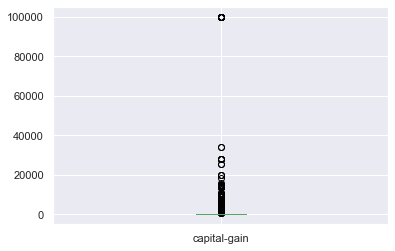

In [2151]:
train['capital-gain'].plot(kind='box')

Z grafu vyššie môžeme vidieť, že 'capital-gain' obsahuje veľmi vychýlené hodnoty. Nahradíme teda všetky hodnoty vyššie ako 20000 za 95 percentil.

In [2152]:
def changeCapGain(df):
    list = df.index[df['capital-gain'] > 20000].tolist()
    df.loc[list, 'capital-gain'] = np.percentile(df['capital-gain'], 95)
    return df

train = changeCapGain(train)

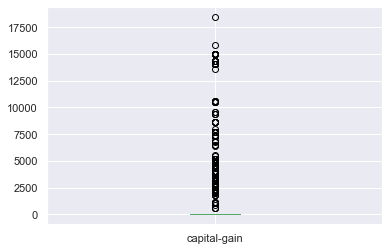

In [2153]:
train['capital-gain'].plot(kind='box')

Z grafu vyššie môžeme vidieť, že sa znížili hodnoty v 'capital-gain'. Aktuálne dosahuje najvyššie číslo hodnotu približne 18 tisíc oproti pôvodným 100 tisíc.

### 5.2.14 skewness_oxygen

In [2154]:
train["skewness_oxygen"].describe()

count    3932.000000
mean     91.321898  
std      108.556015 
min     -1.976976   
25%      12.868466  
50%      68.505049  
75%      127.017151 
max      1191.000837
Name: skewness_oxygen, dtype: float64

In [2155]:
train.index[train['skewness_oxygen'].isnull()].tolist()

[3418]

'skewness_oxygen' obsahuje nulovú hodnotu. Pre jej nahradenie použijeme lineárnu regresiu:

In [2156]:
def setColLinReg(df, col):
    data = df[['mean_glucose','mean_oxygen','std_glucose','std_oxygen','kurtosis_glucose','kurtosis_oxygen','skewness_glucose','skewness_oxygen']]
    noNanData = data[data[col].notnull()].drop(columns=col)
    noNanSG = data[data[col].notnull()][col]
    toFillSG = data[data[col].isnull()].drop(columns=col)
    linreg = LinearRegression()
    linreg.fit(noNanData,noNanSG)
    
    for i, row in toFillSG.iterrows():
        result = linreg.predict(toFillSG)
        df.loc[i, col] = result
        
    return df

train = setColLinReg(train, 'skewness_oxygen')

In [2157]:
train.index[train['skewness_oxygen'].isnull()].tolist()

[]

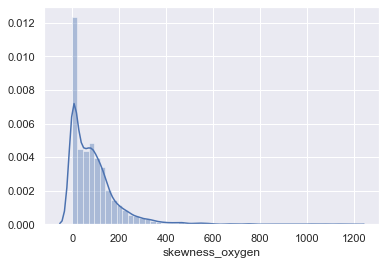

In [2158]:
sns.distplot(train['skewness_oxygen'].dropna(), bins=None)

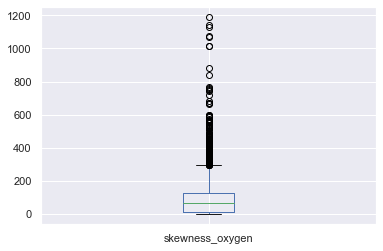

In [2159]:
train['skewness_oxygen'].plot(kind='box')

Z grafu vyššie vidieť, že niektoré hodnoty sú odchýlené. Upravíme teda všetky hodnoty vyššie ako 800 pomocou odmocniny.

In [2160]:
def changeColToSQRT(df, col, value):
    list = df.index[df[col] > value].tolist()
    for i in list:
        df.loc[i, col] = np.sqrt(df.loc[i, col])
    return df

train = changeColToSQRT(train, 'skewness_oxygen', 800)

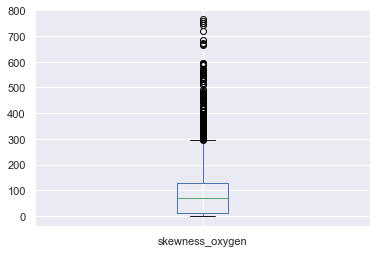

In [2161]:
train['skewness_oxygen'].plot(kind='box')

### 5.2.15 education
Atribút bol už odstránený

### 5.2.16 fnlwgt

In [2162]:
train["fnlwgt"].describe()

count    3933.000000  
mean     190983.830664
std      104075.857757
min      14878.000000 
25%      119359.000000
50%      179423.000000
75%      238008.000000
max      972354.000000
Name: fnlwgt, dtype: float64

In [2163]:
train.index[train['fnlwgt'].isnull()].tolist()

[]

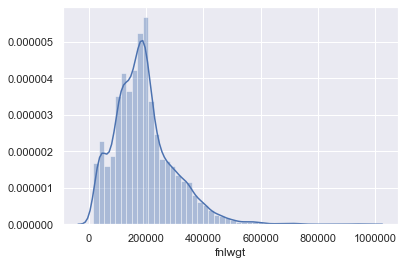

In [2164]:
sns.distplot(train['fnlwgt'].dropna(), bins=None)

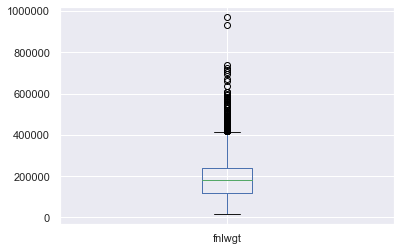

In [2165]:
train['fnlwgt'].plot(kind='box')

In [2166]:
train = changeColToSQRT(train, 'fnlwgt', 800000)

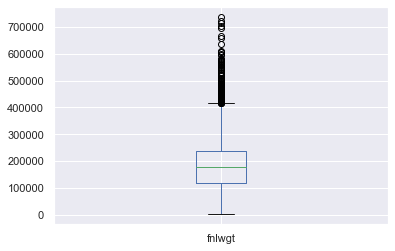

In [2167]:
train['fnlwgt'].plot(kind='box')

Vychýlené hodnoty sme normalizovali pomocou odmocniny.

### 5.2.17 class
Po deduplikácií datasetu other sa nám doplnili všetky chýbajúce hodnoty atribútu class. Tento atribút teda nemusíme nijako spracovať.

In [2168]:
train["class"].isnull().unique()

array([False])

### 5.2.18 income
Atribút income obsahuje 2 hodnoty - >50k a <=50k -> keďže tieto intervaly nevieme nijako zmenšiť, môžeme vytvoriť nový atribút is>50k, ktorý bude 1 ak je príjem väčší ako 50k, ak 0 tak je príjem menší alebo rovný ako 50k.

In [2169]:
train.income.unique()

array([' >50K', ' <=50K'], dtype=object)

In [2170]:
def changeIncome(row):
    if str(row['is>50K']) == '>50K':
        return 1
    else:
        return 0

def fixIncome(df):
    df = df.rename(columns={'income' : 'is>50K'})
    df["is>50K"] = df["is>50K"].str.strip()
    df["is>50K"] = df.apply(lambda row: changeIncome(row), axis=1)
    return df

train = fixIncome(train)    

In [2171]:
train["is>50K"].unique()

array([1, 0], dtype=int64)

Vznikol nám nový spojitý atribút is>50K - ak je hodnota 1, ročný príjem subjektu je väčší ako 50K, ak 0 je menší 

### 5.2.20 capital-loss
Ako prvé skontrolujeme či sa v stĺpci nachádzajú nejaké hodnoty NaN. Ak áno, nahradíme ich mediánom. Následne skontrolujeme vychýlené hodnoty.

In [2172]:
train["capital-loss"].describe()

count    3932.000000
mean     88.158952  
std      402.222704 
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      0.000000   
max      3900.000000
Name: capital-loss, dtype: float64

In [2173]:
train['capital-loss'].unique()

array([   0., 2002., 1564., 1887., 2057., 1719., 1977., 1485., 1762.,
       2042., 1741., 2258., 2415., 1669., 1408., 1902., 1848.,   nan,
       2559., 1573., 1980.,  653., 1726., 1876., 1628., 2238., 2377.,
       2179., 1721., 2051., 1672., 1590., 1740., 1579., 1651., 1602.,
       1617., 2001., 2352., 3900., 1092.,  625.,  810., 2603., 2205.,
       2339., 1735., 1504., 1668.])

Môžeme vidieť, že v 'capital-loss' sa nachádza minimálne jedna hodnota NaN. Je teda potrebné ju nahradiť mediánom

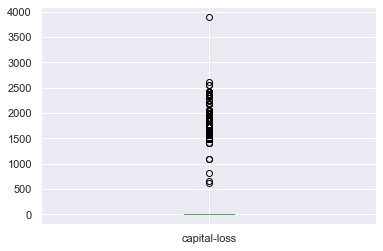

In [2174]:
train['capital-loss'].plot(kind='box')

Z grafu vyššie je vidieť, že 'capital-loss' obsahuje vychýlené hodnoty. Odmocníme teda všetky hodnoty vyššie ako 2500, čím odstránime niektoré vychýlené hodnoty

In [2175]:
def changeCapLoss(df):
    nans = df.index[df['capital-loss'].isnull()].tolist()
    df.loc[nans,'capital-loss'] = df['capital-loss'].median()
    changeColToSQRT(df, 'capital-loss', 2500)
    return df


train = changeCapLoss(train)

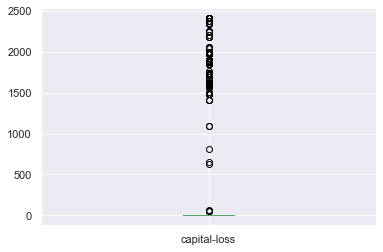

In [2176]:
train['capital-loss'].plot(kind='box')

### 5.2.21 mean_oxygen
Mame veľký rozdiel medzi min a max hodnotami tohoto atribútu - pravdepodobne sa jedná o nejaké outliery. Vykreslíme si aj plotbox, aby sme sa uistili.

In [2177]:
train.mean_oxygen.describe()

count    3933.000000
mean     18.476772  
std      34.789202  
min      0.213211   
25%      2.065217   
50%      3.236622   
75%      12.631271  
max      217.371238 
Name: mean_oxygen, dtype: float64

In [2178]:
np.percentile(train["mean_oxygen"], 95)

107.68979933999981

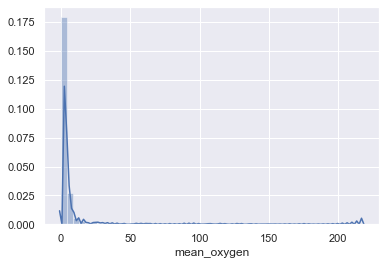

In [2179]:
sns.distplot(train[train["class"] == 0]['mean_oxygen'].dropna(), bins=None)

In [2180]:
len(train[(train.mean_oxygen < 200) & (train["class"] == 0)])

2926

In [2181]:
len(train[(train.mean_oxygen >= 200)])

3

Na grafe vidime, že sa nejedná o klasický long-tail graf - pri hodnote 200 sa nám opätovne tvorí "kopček". Toto je podozrivé, preto znormalizujeme všetky atribúty, kde hodnota > 150 pomocou odmocniny.

In [2182]:
def fixMeanOxygen(df):

    changeColToSQRT(df, 'mean_oxygen', 150)
    return df

train = fixMeanOxygen(train)

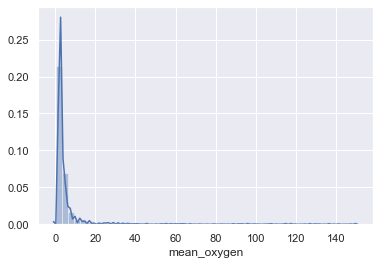

In [2183]:
sns.distplot(train[train["class"] == 0]['mean_oxygen'].dropna(), bins=None)

### 5.2.22 hours-per-week
Vo výpise nižšie môžeme vidieť aké rôzne hodnoty sú zapísané v stĺpci 'hours-per-week'. Pre nahradanie NaN hodnôt využijeme medián. Následne pacientov rozdelíme do skupín podľa počtu odpracovaných hodín nasledovne:

PartTime = hours-per-week <= 30 <br>
FullTime = 30 < hours-per-week <= 60 <br>
OverTime = 60 < hours-per-week <= 80 <br>
OverWork = 80 < hours-per-week

In [2184]:
train['hours-per-week'].unique()

array([35., 50., 52., 40., 15., 60.,  8., 47., 24., 16., 25., 38., 45.,
       20., 48.,  5., 55., 30., 70., 10., 12., 37., 81., 14., 64., 28.,
       32., 42., 78., 18., 26., 13., 36.,  1., 72., 46., 73., 65., 22.,
       90.,  4.,  3., 23., 44., 56., nan, 75., 34., 66., 43., 85., 80.,
        6., 84., 99., 54.,  7., 41., 53., 31., 57., 27., 62., 39., 49.,
       33., 86., 77., 11., 76., 21.,  2., 17., 63., 98., 19., 61., 68.,
       97.])

In [2185]:
train['hours-per-week'].median()

40.0

In [2186]:
def changeHours(df):
    nullIndices = df.index[df['hours-per-week'].isnull()].tolist()
    df.loc[nullIndices,'hours-per-week'] = df['hours-per-week'].median()
    
    rowsPT = df.index[df['hours-per-week'] <= 30].tolist()
    rowsFT = df.index[(df['hours-per-week'] > 30) & (df['hours-per-week'] <= 60)].tolist()
    rowsOT = df.index[(df['hours-per-week'] > 60) & (df['hours-per-week'] <= 80)].tolist()
    rowsOW = df.index[df['hours-per-week'] > 80].tolist()
    
    df.loc[rowsPT, 'hours-per-week'] = 'Part-time'
    df.loc[rowsFT, 'hours-per-week'] = 'Full-time'
    df.loc[rowsOT, 'hours-per-week'] = 'Over-time'
    df.loc[rowsOW, 'hours-per-week'] = 'Overwork'
    return df

train = changeHours(train)
train = oneHotEncoding(train, "hours-per-week")
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 47 columns):
isMale              3933 non-null int64
kurtosis_oxygen     3933 non-null float64
isMarried           3933 non-null int64
isPregnant          3933 non-null int64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null float64
is>50K              3933 non-null int64
native-country      3931 non-null object
capital-loss        3933 non-null float64
mean_oxygen         3933 non-null float64
race                3933 non-null object
workclass           3700 non-null object
mean_glucose        3933 non-null float64
std_glucose         3933 non-null float64
kurtosis_glucose    3933 non-null float64
skewness_glucose    3933 non-null float64
isOld               3933 non-null int64
isSenior            3933 non-null int64
isAdult             3933 n

### 5.2.23 race a native-country
Na začiatku záznamov atribútu race sa nachádzajú zbytočné medzery. Neobsahuje žiadne nulové hodnoty, čiže vytvoríme jednoduchú funkciu ktorá odstráni tieto medzery a potom použijeme opätovne one-hot-encoding.

In [2187]:
train["race"].unique()

array([' White', ' Black', ' Asian-Pac-Islander', ' Other',
       ' Amer-Indian-Eskimo'], dtype=object)

In [2188]:
train.race.describe()

count     3933  
unique    5     
top        White
freq      3397  
Name: race, dtype: object

In [2189]:
len(train[train.race == " Other"])

28

In [2190]:
len(train[train.race == " Black"])

360

Z výpisov sme zistili, že najčastejšie vyskytujúca sa rasa je White s počtom 3397. Rasa Black sa vyskytuje v 360 záznamoch. Zvyšné rasy majú pomerne malú reprezentáciu v datasete, preto ich môžeme zoskupiť všetky pod hodnotu Other(tá ma len chabých 28 záznamov).

In [2191]:
def changeRace(row):    
    
    if str(row['race']) in ("Other", "Asian-Pac-Islander", "Amer-Indian-Eskimo"):
        return "Other(race)";
    else:
        return row['race'];
    
    
def fixRace(df):
    
    df['race'] = df['race'].str.strip()
    df['race'] = df.apply(lambda row: changeRace(row), axis=1)
    return df;


train = fixRace(train)
train = oneHotEncoding(train, "race");

In [2192]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 49 columns):
isMale              3933 non-null int64
kurtosis_oxygen     3933 non-null float64
isMarried           3933 non-null int64
isPregnant          3933 non-null int64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null float64
is>50K              3933 non-null int64
native-country      3931 non-null object
capital-loss        3933 non-null float64
mean_oxygen         3933 non-null float64
workclass           3700 non-null object
mean_glucose        3933 non-null float64
std_glucose         3933 non-null float64
kurtosis_glucose    3933 non-null float64
skewness_glucose    3933 non-null float64
isOld               3933 non-null int64
isSenior            3933 non-null int64
isAdult             3933 non-null int64
isYoung-adult       3933 no

### native-country
Krajiny budeme združovať podľa oblasti, v ktorej sa nachádzajú (Európa, Ázia....). Na nahradenie NaN hodnôt použijeme algorimtus KNN. Predikovať chceme na základe rasy a income (niektoré krajiny majú nižšie platy, tak to možno bude dobrý prediktor).

In [2193]:
train["native-country"].unique()

array([' United-States', ' Mexico', ' Philippines', ' Jamaica',
       ' Vietnam', ' China', ' Cuba', ' ?', ' Poland', ' Thailand',
       ' India', ' Puerto-Rico', ' Iran', ' Canada', ' South', ' Italy',
       ' Japan', ' Nicaragua', ' England', nan, ' Trinadad&Tobago',
       ' Hong', ' Greece', ' Columbia', ' Scotland', ' France',
       ' Ecuador', ' El-Salvador', ' Taiwan', ' Germany', ' Peru',
       ' Portugal', ' Guatemala', ' Laos', ' Dominican-Republic',
       ' Yugoslavia', ' Hungary', ' Haiti', ' Honduras', ' Ireland'],
      dtype=object)

In [2194]:
def changeCountry(row):    
    
    if str(row['native-country']) in ("Hungary", "Yugoslavia", "Ireland", "Italy", "England", "Greece", "Poland", "Scotland", "France", "Germany", "Portugal"):
        return "European";
    elif str(row['native-country']) in ("?", "??", "Nan", "nan"):
        return np.NaN;
    elif str(row['native-country']) in ("Ecuador", ""):
        return "African";
    elif str(row['native-country']) in ("United-States", "Mexico", "Canada", "Puerto-Rico"):
        return "North-American";
    elif str(row['native-country']) in ("Japan", "Vietnam", "China", "Thailand", "Laos", "Hong", "Taiwan", "Philippines", "India", "Iran"):
        return "Asian";
    elif str(row['native-country']) in ("Columbia", "Peru"):
        return "South-American";
    elif str(row['native-country']) in ("Guatemala", "Honduras", "Nicaragua", "El-Salvador"):
        return "Central-American";
    else:
        return "Other(country)"
    
    
def fixCountry(df):
    df['native-country'] = df['native-country'].str.strip()
    df['native-country'] = df.apply(lambda row: changeCountry(row), axis=1)
    knn = KNeighborsClassifier(n_neighbors=7, weights = "distance")
    fitDf = df[df['native-country'].notnull()]
    predictDf = df[df['native-country'].isnull()]
    x_column = ['isBlack', 'isWhite', 'isOther(race)', 'is>50K']
    y_column = 'native-country'
    knn.fit(fitDf[x_column], fitDf[y_column])
    predictDf['native-country'] = knn.predict(predictDf[x_column])
    df[df['native-country'].isnull()] = predictDf;
    return df;

train = fixCountry(train)
train = oneHotEncoding(train, "native-country")

C:\Users\6430u\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [2195]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 55 columns):
isMale                3933 non-null int64
kurtosis_oxygen       3933 non-null float64
isMarried             3933 non-null int64
isPregnant            3933 non-null int64
std_oxygen            3933 non-null float64
capital-gain          3933 non-null float64
skewness_oxygen       3933 non-null float64
fnlwgt                3933 non-null float64
class                 3933 non-null float64
is>50K                3933 non-null int64
capital-loss          3933 non-null float64
mean_oxygen           3933 non-null float64
workclass             3700 non-null object
mean_glucose          3933 non-null float64
std_glucose           3933 non-null float64
kurtosis_glucose      3933 non-null float64
skewness_glucose      3933 non-null float64
isOld                 3933 non-null int64
isSenior              3933 non-null int64
isAdult               3933 non-null int64
isYoung-adult         3933 n

### 5.2.24 workclass
Atribút workclass nadobúda množstvo rôznych hodnôt. Vytvoríme si 4 základné skupiny - Gov, Self-emp, Private a Without-pay. Hodnoty obsahujúce ? a hodnotu Nan (pozor malé n) budeme meniť na NaN, pričom všetky NaN hodnoty následne nahradíme pomocou k nearest neighbour.

In [2196]:
train.workclass.unique()

array([' Self-emp-not-inc', ' Private', ' State-gov', ' Self-emp-inc',
       ' ?', 'private', '??', nan, ' Local-gov', 'Nan', ' Federal-gov',
       'local-gov', 'self-emp-not-inc', 'state-gov', 'self-emp-inc',
       'federal-gov', '?', ' Without-pay'], dtype=object)

In [2197]:
def changeWorkclass(row):    
    
    if str(row['workclass']) in ("private", "Private"):
        return "Private";
    elif str(row['workclass']) in ("?", "??", "Nan"):
        return np.NaN;
    elif str(row['workclass']) in ("self-emp-not-inc", "Self-emp-not-inc", "Self-emp-inc", "self-emp-inc"):
        return "Self-emp";
    elif str(row['workclass']) in ("Local-gov", "local-gov", "Federal-gov", "federal-gov", "State-gov", "state-gov"):
        return "Gov";
    else:
        return row['workclass'];
    
    
def fixWorkclass(df):
    df['workclass'] = df['workclass'].str.strip()
    df['workclass'] = df.apply(lambda row: changeWorkclass(row), axis=1)
    knn = KNeighborsClassifier(n_neighbors=7, weights = "distance")
    fitDf = df[df['workclass'].notnull()]
    predictDf = df[df['workclass'].isnull()]
    x_column = ['is>50K', 'isPart-time', 'isFull-time', 'isOver-time', 'isOverwork', 'isOld', 'isSenior', 'isAdult', 'isYoung-adult', 'isChild']
    y_column = 'workclass'
    knn.fit(fitDf[x_column], fitDf[y_column])
    predictDf['workclass'] = knn.predict(predictDf[x_column])
    df[df['workclass'].isnull()] = predictDf;
    return df;


train = fixWorkclass(train)
train = oneHotEncoding(train, "workclass")

C:\Users\6430u\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [2198]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 58 columns):
isMale                3933 non-null int64
kurtosis_oxygen       3933 non-null float64
isMarried             3933 non-null int64
isPregnant            3933 non-null int64
std_oxygen            3933 non-null float64
capital-gain          3933 non-null float64
skewness_oxygen       3933 non-null float64
fnlwgt                3933 non-null float64
class                 3933 non-null float64
is>50K                3933 non-null int64
capital-loss          3933 non-null float64
mean_oxygen           3933 non-null float64
mean_glucose          3933 non-null float64
std_glucose           3933 non-null float64
kurtosis_glucose      3933 non-null float64
skewness_glucose      3933 non-null float64
isOld                 3933 non-null int64
isSenior              3933 non-null int64
isAdult               3933 non-null int64
isYoung-adult         3933 non-null int64
isChild               3933 no

### medical-info
Atribút medical-info obsahuje 4 atribúty - mean_glucose, std_glucose, kurtosis_glucose a skewness_glucose. Vyriešený bol už v predošlom odovzdaní, pričom ho rieši funkcia fixMedicalInfo.

### 5.2.25 mean_glucose

In [2199]:
train.mean_glucose.describe()

count    3933.000000
mean     101.277271 
std      33.560209  
min      6.187500   
25%      87.742188  
50%      110.664062 
75%      124.132812 
max      189.734375 
Name: mean_glucose, dtype: float64

In [2200]:
train.index[train['mean_glucose'].isnull()].tolist()

[]

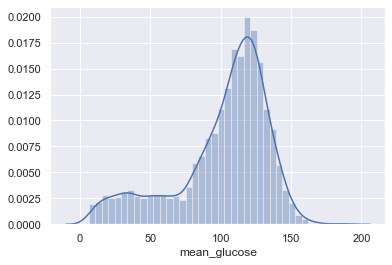

In [2201]:
sns.distplot(train['mean_glucose'].dropna(), bins=None)

### 5.2.26 std_glucose

In [2202]:
train.std_glucose.describe()

count    3933.000000
mean     45.174684  
std      7.607881   
min      25.695250  
25%      40.165726  
50%      45.887420  
75%      50.369068  
max      91.206475  
Name: std_glucose, dtype: float64

In [2203]:
train.index[train['std_glucose'].isnull()].tolist()

[]

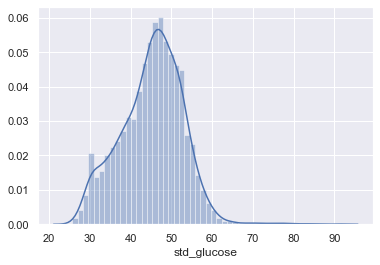

In [2204]:
sns.distplot(train['std_glucose'].dropna(), bins=None)

Graf vyzerá OK

### 5.2.27 kurtosis_glucose

In [2205]:
train.kurtosis_glucose.describe()

count    3933.000000
mean     1.009346   
std      1.575232   
min      0.000154   
25%      0.141069   
50%      0.330427   
75%      0.811356   
max      8.069522   
Name: kurtosis_glucose, dtype: float64

In [2206]:
train.index[train['kurtosis_glucose'].isnull()].tolist()

[]

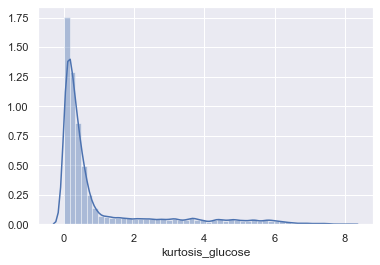

In [2207]:
sns.distplot(train['kurtosis_glucose'].dropna(), bins=None)

Obyčajný long-tail graf, čiže v údajoch nič meniť nebudeme.

### 5.2.28 skewness_glucose

In [2208]:
train.skewness_glucose.describe()

count    3933.000000
mean     4.416022   
std      9.589714   
min      0.000108   
25%      0.229741   
50%      0.524947   
75%      2.081514   
max      68.101622  
Name: skewness_glucose, dtype: float64

In [2209]:
train.index[train['skewness_glucose'].isnull()].tolist()

[]

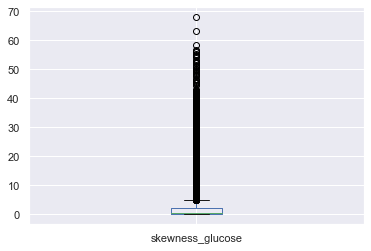

In [2235]:
train.skewness_glucose.plot(kind = "box")

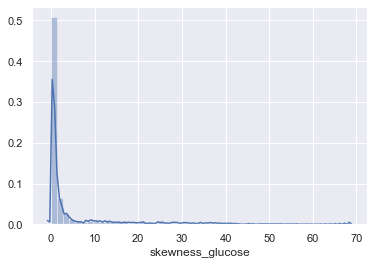

In [2210]:
sns.distplot(train['skewness_glucose'].dropna(), bins=None)

Jedná sa o obyčajný long-tail graf, čiže v údajoch nič meniť nebudeme.

### Finálna podoba
Po všetkých úpravách vyzerajú všetky atribúty v našom dataframe takto

In [2211]:
train.info()
train.isBlack.unique()
#train["hours-per-week"].unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 58 columns):
isMale                3933 non-null int64
kurtosis_oxygen       3933 non-null float64
isMarried             3933 non-null int64
isPregnant            3933 non-null int64
std_oxygen            3933 non-null float64
capital-gain          3933 non-null float64
skewness_oxygen       3933 non-null float64
fnlwgt                3933 non-null float64
class                 3933 non-null float64
is>50K                3933 non-null int64
capital-loss          3933 non-null float64
mean_oxygen           3933 non-null float64
mean_glucose          3933 non-null float64
std_glucose           3933 non-null float64
kurtosis_glucose      3933 non-null float64
skewness_glucose      3933 non-null float64
isOld                 3933 non-null int64
isSenior              3933 non-null int64
isAdult               3933 non-null int64
isYoung-adult         3933 non-null int64
isChild               3933 no

array([0, 1], dtype=int64)

Nemáme žiadne chýbajúce hodnoty a všetky naše atribúty sú spojité, čiže náš dataset je pripravený na daľšiu fázu projektu.

## 5.3 Znovupoužiteľnosť predspracovania
Na zaistenie znovupoužitelnosti nášho predspracovania použijeme Pipelines z knižnice Scikit. Alebo to dam len do jednej velkej funkcie a tej dam ako parameter zdrojovy a cielovy dataset? idk

## 5.4 Opätovná realizácia prieskumnej analýzy
V tejto sekcií opätovne vykonáme dôležité časti prieskumnej analýzy - keďže sme modifikovali údaje, je možné, že dostaneme odlišné výsledky. Budeme sa však pozerať už len na dôležité atribúty, taktiež môžeme opätovne zobraziť korelačnú tabuľku a porovnať zmeny pri koreláciach s predikovanou premennou - či nám nevznikli nové prediktory.

### 5.4.1 isMale
Pri pohlaví nenastala žiadna výrazná zmena, muži sú reprezentovaný číslom 1 a ženy číslom 0.

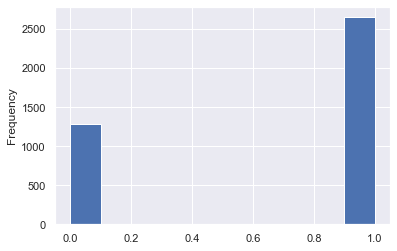

In [2212]:
train.isMale.plot(kind = "hist")

In [2213]:
men_count = len(train[(train.isMale == 1)])
men_count / len(train) * 100

67.42944317315028

Percento mužov je prakticky totožné ako v pôvodnej analýze, malý rozdiel je z dôvodu kontroly pohlavia prostredníctvom atribútu relationship(v tomto momente je už zmazaný)

### 5.4.2 class
Počet subjektov sa zmenil kvôli deduplikácií, čo malo samozrejme dopad (mierny) aj na počet jednotlivcov s class 0 a 1.

Counter({0.0: 2958, 1.0: 1014})


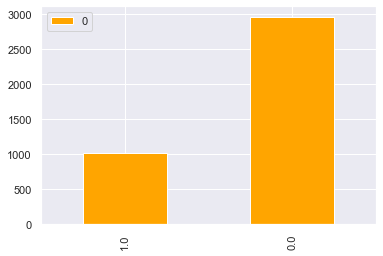

In [2250]:
df = other[(other["class"] == 1) | (other["class"] == 0)]["class"]
count = Counter(df)
df = pd.DataFrame.from_dict(count, orient='index')
ax = df.plot(kind='bar', legend = True, color = "orange")
print(count)

Po predspracovaní

Counter({0.0: 2929, 1.0: 1004})


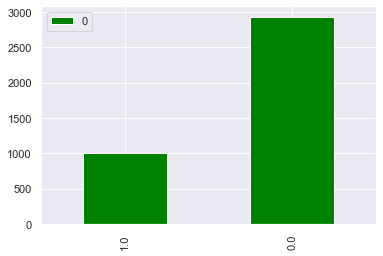

In [2251]:
df = train[(train["class"] == 1) | (train["class"] == 0)]["class"]
count = Counter(df)
df = pd.DataFrame.from_dict(count, orient='index')
ax = df.plot(kind='bar', legend = True, color = "green")
print(count)

### 5.4.3 Glucose a oxygen (class)
V tejto sekcií porovnáme všetky hodnoty glukózy a kyslíka v krvi medzi ľudmi s cukrovkou a bez cukrovky. Prvé grafy sú vždy z pôvodného datasetu, druhé (oranžovo-modré) sú z upraveného datasetu.

#### mean_oxygen

Text(0.5, 1, 'class = 0')

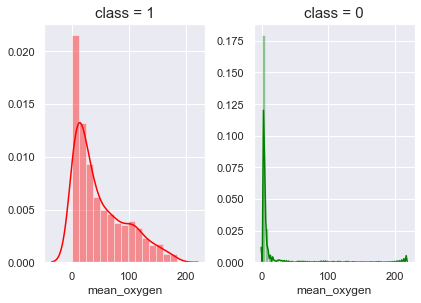

In [2215]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other[other["class"]== 1]['mean_oxygen'].dropna(),bins=None, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['mean_oxygen'].dropna(),bins=None, color = "green", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

Text(0.5, 1, 'class = 0')

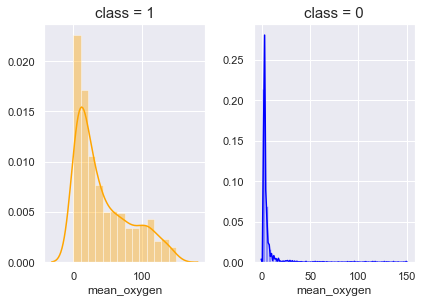

In [2216]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(train[train["class"]== 1]['mean_oxygen'].dropna(),bins=None, color = "orange", ax = ax[0])
sns.distplot(train[train["class"]== 0]['mean_oxygen'].dropna(),bins=None, color = "blue", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

Ľudia bez cukrovky majú v priemere nižšiu hladinu kyslíka v krvi v porovnaní s ľudmi s cukrovkou.

#### std_oxygen

Text(0.5, 1, 'class = 0')

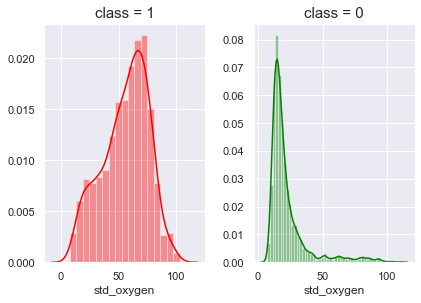

In [2217]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other[other["class"]== 1]['std_oxygen'].dropna(),bins=None, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['std_oxygen'].dropna(),bins=None, color = "green", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

Text(0.5, 1, 'class = 0')

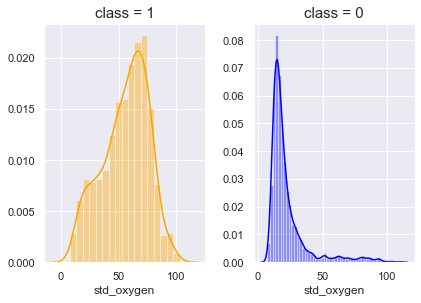

In [2218]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(train[train["class"]== 1]['std_oxygen'].dropna(),bins=None, color = "orange", ax = ax[0])
sns.distplot(train[train["class"]== 0]['std_oxygen'].dropna(),bins=None, color = "blue", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

#### skewness_oxygen

Text(0.5, 1, 'class = 0')

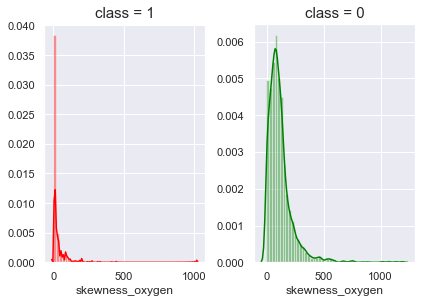

In [2219]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other[other["class"]== 1]['skewness_oxygen'].dropna(),bins=None, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['skewness_oxygen'].dropna(),bins=None, color = "green", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

Text(0.5, 1, 'class = 0')

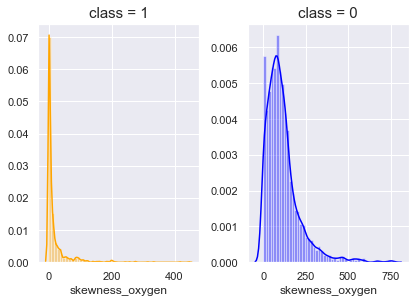

In [2220]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(train[train["class"]== 1]['skewness_oxygen'].dropna(),bins=None, color = "orange", ax = ax[0])
sns.distplot(train[train["class"]== 0]['skewness_oxygen'].dropna(),bins=None, color = "blue", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

#### kurtosis_oxygen

Text(0.5, 1, 'class = 0')

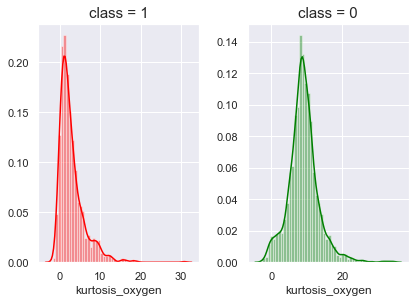

In [2221]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other[other["class"]== 1]['kurtosis_oxygen'].dropna(),bins=None, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['kurtosis_oxygen'].dropna(),bins=None, color = "green", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

Text(0.5, 1, 'class = 0')

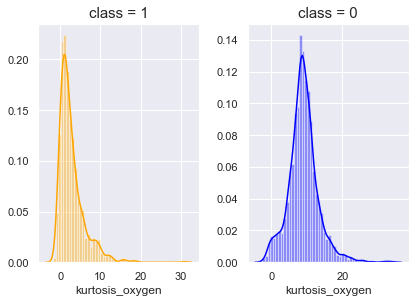

In [2222]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(train[train["class"]== 1]['kurtosis_oxygen'].dropna(),bins=None, color = "orange", ax = ax[0])
sns.distplot(train[train["class"]== 0]['kurtosis_oxygen'].dropna(),bins=None, color = "blue", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

#### mean_glucose

Text(0.5, 1, 'class = 0')

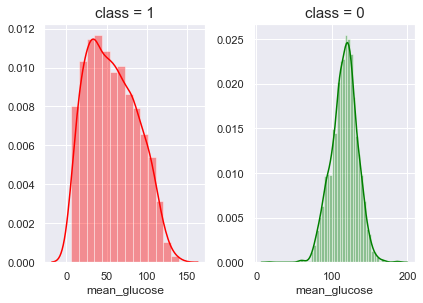

In [2074]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other[other["class"]== 1]['mean_glucose'].dropna(),bins=None, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['mean_glucose'].dropna(),bins=None, color = "green", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

Text(0.5, 1, 'class = 0')

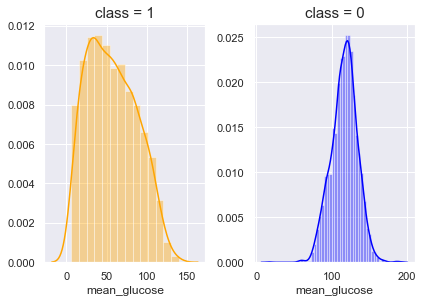

In [2086]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(train[train["class"]== 1]['mean_glucose'].dropna(),bins=None, color = "orange", ax = ax[0])
sns.distplot(train[train["class"]== 0]['mean_glucose'].dropna(),bins=None, color = "blue", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

#### std_glucose

Text(0.5, 1, 'class = 0')

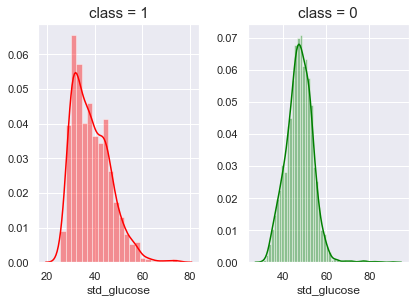

In [2075]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other[other["class"]== 1]['std_glucose'].dropna(),bins=None, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['std_glucose'].dropna(),bins=None, color = "green", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

Text(0.5, 1, 'class = 0')

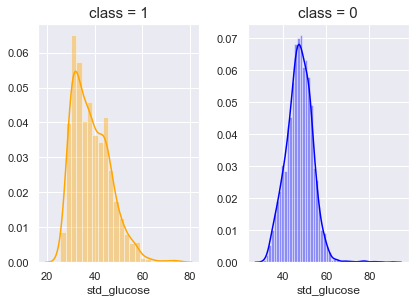

In [2087]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(train[train["class"]== 1]['std_glucose'].dropna(),bins=None, color = "orange", ax = ax[0])
sns.distplot(train[train["class"]== 0]['std_glucose'].dropna(),bins=None, color = "blue", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

#### skewness_glucose

Text(0.5, 1, 'class = 0')

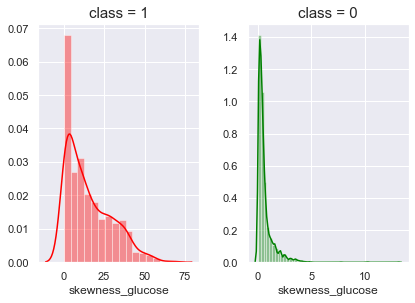

In [2076]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other[other["class"]== 1]['skewness_glucose'].dropna(),bins=None, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['skewness_glucose'].dropna(),bins=None, color = "green", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

Text(0.5, 1, 'class = 0')

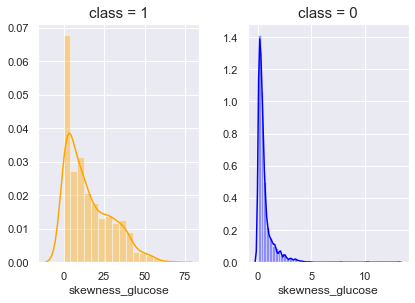

In [2088]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(train[train["class"]== 1]['skewness_glucose'].dropna(),bins=None, color = "orange", ax = ax[0])
sns.distplot(train[train["class"]== 0]['skewness_glucose'].dropna(),bins=None, color = "blue", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

#### kurtosis_glucose

Text(0.5, 1, 'class = 0')

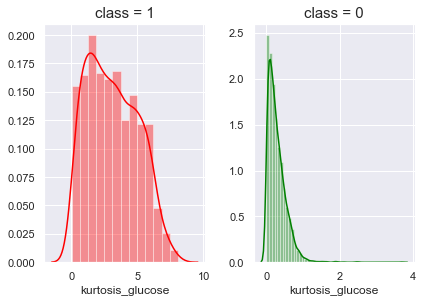

In [2077]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(other[other["class"]== 1]['kurtosis_glucose'].dropna(),bins=None, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['kurtosis_glucose'].dropna(),bins=None, color = "green", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

Text(0.5, 1, 'class = 0')

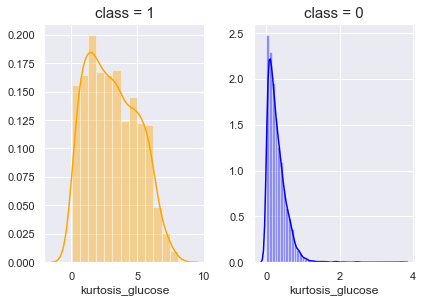

In [2089]:
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(train[train["class"]== 1]['kurtosis_glucose'].dropna(),bins=None, color = "orange", ax = ax[0])
sns.distplot(train[train["class"]== 0]['kurtosis_glucose'].dropna(),bins=None, color = "blue", ax = ax[1])
ax[0].set_title('class = 1', fontsize=15)
ax[1].set_title('class = 0', fontsize=15)

#### Porovnanie korelácie normovaného atribútu mean_oxygen a std_oxygen

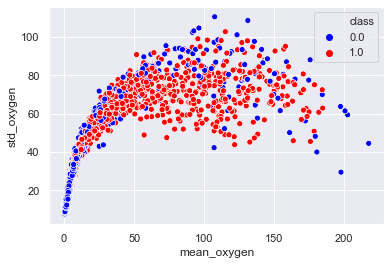

In [2228]:
sns.scatterplot(x='mean_oxygen', y='std_oxygen', hue='class', data=other, palette = ['blue', 'red'])

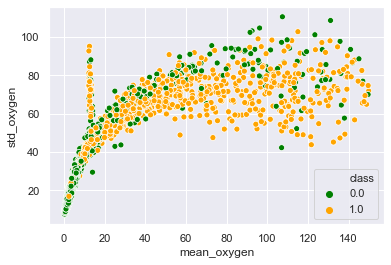

In [2227]:
sns.scatterplot(x='mean_oxygen', y='std_oxygen', hue='class', data=train, palette = ['green', 'orange'])

In [2231]:
other.corr()["mean_oxygen"].std_oxygen

0.8021306072761003

In [2230]:
train.corr()["mean_oxygen"].std_oxygen

0.8164949448406611

Vidíme, že po modifikácií dát pomocou odmocniny sa korelácia zvýšila.

### 5.4.4 Korelačná matica

In [2079]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

In [2223]:
train.corr()['class']

isMale                0.001255
kurtosis_oxygen      -0.556919
isMarried             0.008289
isPregnant           -0.007567
std_oxygen            0.648825
capital-gain          0.001614
skewness_oxygen      -0.423535
fnlwgt               -0.015627
class                 1.000000
is>50K               -0.003375
capital-loss         -0.005017
mean_oxygen           0.535712
mean_glucose         -0.774910
std_glucose          -0.501119
kurtosis_glucose      0.785086
skewness_glucose      0.676589
isOld                 0.158041
isSenior              0.269209
isAdult              -0.178649
isYoung-adult        -0.150280
isChild              -0.039699
isExec                0.004639
isCraft              -0.019271
isProt                0.005844
isSales              -0.003279
isProf                0.012754
isHandlClean         -0.000463
isMachineInspct      -0.023151
isOther               0.030307
isAdm                -0.022148
isTechSupp           -0.005578
isTranspMov           0.019649
isFarm  

In [2224]:
other.corr()['class']

kurtosis_oxygen    -0.555643
education-num      -0.004584
std_oxygen          0.650266
capital-gain       -0.008443
skewness_oxygen    -0.385221
fnlwgt             -0.017244
class               1.000000
capital-loss       -0.006092
mean_oxygen         0.518284
hours-per-week      0.015091
mean_glucose       -0.775109
std_glucose        -0.500295
kurtosis_glucose    0.784912
skewness_glucose    0.675967
Name: class, dtype: float64

Z korelácií vidíme, že nám nevznikol žiaden nový výrazný prediktor cukrovky. Najvhodnejším prediktorom stále ostáva atribút kurtosis_glucose a mean_glucose.